In [ ]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split



# Basisstijl voor plots

plt.rcParams["figure.figsize"] = (10, 6)

plt.rcParams["axes.grid"] = True



# ============================================================================

# STAP 1: DATA INLADEN EN EERSTE VERKENNING

# ============================================================================

print("="*80)

print("STAP 1: DATA INLADEN EN EERSTE VERKENNING")

print("="*80)



# Laad de dataset

df = pd.read_csv("ML-sleep_health_lifestyle_dataset.csv")



print(f"\nDataset geladen met {df.shape[0]} rijen en {df.shape[1]} kolommen")

print("\nEerste 5 rijen:")

display(df.head())

In [ ]:
# ============================================================================
# STAP 2: DATA INSPECTIE EN KWALITEITSCONTROLE
# ============================================================================
print("\n" + "="*80)
print("STAP 2: DATA INSPECTIE EN KWALITEITSCONTROLE")
print("="*80)

print("\nInformatie over datatypes en geheugengebruik:")
df.info()

print("\n" + "-"*80)
print("CONTROLE OP ONTBREKENDE WAARDEN")
print("-"*80)
missing_values = df.isnull().sum()
missing_pct = 100 * df.isnull().sum() / len(df)
missing_table = pd.DataFrame({
    'Aantal Missing': missing_values,
    'Percentage': missing_pct
})
print(missing_table[missing_table['Aantal Missing'] > 0])

if missing_table['Aantal Missing'].sum() == 0:
    print("\n✓ Geen ontbrekende waarden gevonden in de dataset")
    print("Dit is gunstig voor modelontwikkeling omdat we geen imputatiestrategieën nodig hebben.")
else:
    print("\n⚠ Er zijn ontbrekende waarden die behandeld moeten worden")

print("\n" + "-"*80)
print("BESCHRIJVENDE STATISTIEKEN - NUMERIEKE VARIABELEN")
print("-"*80)
display(df.describe())





In [ ]:
# ============================================================================
# STAP 3: TARGET VARIABELE ANALYSE
# ============================================================================
print("\n" + "="*80)
print("STAP 3: TARGET VARIABELE ANALYSE")
print("="*80)

print("\nDe target variabele 'Sleep Disorder' vormt de basis voor ons classificatieprobleem.")
print("We onderzoeken de verdeling van klassen om te bepalen of we te maken hebben met")
print("class imbalance en of dit speciale aandacht vereist tijdens modeltraining.\n")

# Vervang NaN in Sleep Disorder met 'None'
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

print("Verdeling van Sleep Disorder:")
class_distribution = df['Sleep Disorder'].value_counts()
print(class_distribution)
print(f"\nPercentages:")
print(df['Sleep Disorder'].value_counts(normalize=True) * 100)

plt.figure(figsize=(8, 5))
df['Sleep Disorder'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c', '#3498db'])
plt.title("Verdeling van Sleep Disorder Klassen", fontsize=14, fontweight='bold')
plt.xlabel("Klasse")
plt.ylabel("Aantal observaties")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n" + "-"*80)
print("INTERPRETATIE VAN KLASSENBALANS")
print("-"*80)

# Bereken imbalance ratio
min_class = class_distribution.min()
max_class = class_distribution.max()
imbalance_ratio = max_class / min_class

print(f"\nImbalance ratio (grootste/kleinste klasse): {imbalance_ratio:.2f}")

if imbalance_ratio < 1.5:
    print(" De klassen zijn redelijk gebalanceerd. Standaard modeltraining is geschikt.")
elif imbalance_ratio < 3:
    print("Er is enige klassenonevenwichtigheid. Overweeg stratified sampling en")
    print("  class_weight='balanced' parameter bij sommige modellen.")
else:
    print("Significante klassenonevenwichtigheid gedetecteerd!")
    print("  Overweeg: SMOTE, class weighting, of stratified k-fold cross-validation.")


In [ ]:

# ============================================================================
# STAP 4: MULTICLASS VS BINARY CLASSIFICATIE - ONDERBOUWING
# ============================================================================
print("\n" + "="*80)
print("STAP 4: MODELTYPE KEUZE - MULTICLASS VS BINARY CLASSIFICATIE")
print("="*80)

print("""
RATIONALE VOOR MULTICLASS CLASSIFICATIE:
-----------------------------------------

Onze target variabele heeft drie categorieën:
1. None (geen slaapstoornis)
2. Insomnia (slapeloosheid)
3. Sleep Apnea (slaapapneu)

WAAROM MULTICLASS IN PLAATS VAN BINARY?
========================================

1. KLINISCHE RELEVANTIE:
   • Insomnia en Sleep Apnea hebben verschillende oorzaken, symptomen en behandelingen
   • Een binair model (wel/geen stoornis) zou deze cruciale distinctie verliezen
   • Voor medisch personeel is het essentieel om het TYPE stoornis te identificeren

2. BEHANDELINGSIMPLICATIES:
   • Insomnia → vaak cognitieve gedragstherapie, slaaphygiëne, medicatie
   • Sleep Apnea → CPAP-apparaat, gewichtsreductie, operatieve ingrepen
   • De aanpak verschilt fundamenteel

3. DIAGNOSTISCHE WAARDE:
   • Verschillende risicoprofielen: Sleep Apnea correleert met BMI en hartslag,
     Insomnia vaak met stress en levensstijlfactoren
   • Een multiclass model kan deze subtiele patronen onderscheiden

4. MODELCOMPLEXITEIT VS INFORMATIEBEHOUD:
   • Trade-off: multiclass is complexer, maar behoudt essentiële informatie
   • In medische context weegt informatieverlies zwaarder dan modelcomplexiteit


""")


In [ ]:

# ============================================================================
# STAP 5: FEATURE TYPE IDENTIFICATIE EN CATEGORISATIE
# ============================================================================
print("\n" + "="*80)
print("STAP 5: FEATURE TYPE IDENTIFICATIE")
print("="*80)

# Numerieke kolommen
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Verwijder Person ID uit numerieke features (is geen predictive feature)
num_cols = [col for col in num_cols if col != 'Person ID']

# Categorische kolommen
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
# Verwijder target uit categorische features
cat_feature_cols = [col for col in cat_cols if col != 'Sleep Disorder']

print(f"\nNumerieke features ({len(num_cols)}):")
for col in num_cols:
    print(f"  • {col}")

print(f"\nCategorische features ({len(cat_feature_cols)}):")
for col in cat_feature_cols:
    unique_values = df[col].nunique()
    print(f"  • {col} ({unique_values} unieke waarden)")
    print(f"    Waarden: {df[col].unique()[:5].tolist()}")


In [ ]:
# ============================================================================
# STAP 6: TRAIN-TEST SPLIT - DATA PARTITIONERING
# ============================================================================
print("\n" + "="*80)
print("STAP 6: TRAIN-TEST SPLIT")
print("="*80)

print("""
DOEL VAN TRAIN-TEST SPLIT:
===========================

We splitsen de data in twee sets:
1. TRAINING SET: Model leert patronen uit deze data
2. TEST SET: Model wordt geëvalueerd op ongeziene data

Dit voorkomt OVERFITTING en geeft realistische performantie schatting.

KRITIEK: SPLIT VOOR ALLE TRANSFORMATIES!
=========================================

We splitsen op de ONBEWERKTE data (na feature identificatie).
Alle bewerkingen (outlier behandeling, encoding, scaling) gebeuren DAARNA,
APART op train en test set.

WAAROM?
- Voorkomt data leakage (test info lekt niet naar train)
- Scaler fit op train, transform op test
- Encoder fit op train, transform op test
- Outlier grenzen bepaald op train, toegepast op test

SPLIT RATIO OVERWEGINGEN:
==========================

OPTIES:
- 90/10: Maximaal trainingsdata, maar kleine test set (minder betrouwbare metrics)
- 80/20: Goede balans (ONZE KEUZE)
- 70/30: Meer test data, maar minder trainingsdata
- 60/40: Bij zeer kleine datasets

ONZE KEUZE: 80/20 SPLIT
========================

Rationale:
- Dataset heeft ~374 samples → 80% = ~299 train, 20% = ~75 test
- 80% training is genoeg voor model learning
- 20% test is acceptabel voor betrouwbare evaluatie (hoewel aan de kleine kant)
- Breed geaccepteerd in ML literatuur (Hastie et al., 2009)

STRATIFIED SAMPLING:
====================

stratify=y zorgt dat de klassenverhouding gelijk blijft in train én test.

Voorbeeld: Als originele data 50% None, 30% Insomnia, 20% Sleep Apnea heeft,
dan heeft ZOWEL train ALS test deze verhoudingen.

WAAROM STRATIFICATION CRUCIAAL IS:
- Voorkomt dat één klasse oververtegenwoordigd is in test set
- Zorgt voor representatieve evaluatie
- Essentieel bij (lichte) class imbalance

RANDOM STATE:
=============
random_state=42 zorgt voor reproduceerbaarheid.
Elke run geeft identieke split → belangrijk voor:
- Vergelijking tussen modellen
- Rapportage van resultaten
- Samenwerking in team
""")

print("\n" + "-"*80)
print("UITVOEREN VAN SPLIT OP ONBEWERKTE DATA")
print("-"*80)

# Scheiding van features en target VOOR encoding/scaling
X = df.drop(['Sleep Disorder', 'Person ID'], axis=1)  # ✓ originele data
y = df['Sleep Disorder']  # nog als string

print(f"\nOriginele dataset:")
print(f"  • X shape: {X.shape}")
print(f"  • y shape: {y.shape}")

# Split op onbewerkte data
X_train, X_test, y_train, y_test = train_test_split(
    X,  # ✓ onbewerkte features
    y,  # ✓ onbewerkte target (nog strings)
    test_size=0.20,
    random_state=42,
    stratify=y
)

print(f"\nTRAINING SET:")
print(f"  • X_train shape: {X_train.shape}")
print(f"  • y_train shape: {y_train.shape}")
print(f"  • Percentage: {100 * len(X_train) / len(X):.1f}%")

print(f"\nTEST SET:")
print(f"  • X_test shape: {X_test.shape}")
print(f"  • y_test shape: {y_test.shape}")
print(f"  • Percentage: {100 * len(X_test) / len(X):.1f}%")

print("\n" + "-"*80)
print("VERIFICATIE VAN STRATIFICATIE")
print("-"*80)

print("\nKlassenverdeling in ORIGINELE data:")
print(y.value_counts(normalize=True).sort_index())

print("\nKlassenverdeling in TRAINING set:")
print(y_train.value_counts(normalize=True).sort_index())

print("\nKlassenverdeling in TEST set:")
print(y_test.value_counts(normalize=True).sort_index())

# Visualisatie van stratificatie
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

y.value_counts(normalize=True).sort_index().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Original Data')
axes[0].set_ylabel('Proportion')
axes[0].set_xlabel('Class')
axes[0].set_ylim(0, 0.6)

y_train.value_counts(normalize=True).sort_index().plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Training Set (80%)')
axes[1].set_ylabel('Proportion')
axes[1].set_xlabel('Class')
axes[1].set_ylim(0, 0.6)

y_test.value_counts(normalize=True).sort_index().plot(kind='bar', ax=axes[2], color='lightcoral')
axes[2].set_title('Test Set (20%)')
axes[2].set_ylabel('Proportion')
axes[2].set_xlabel('Class')
axes[2].set_ylim(0, 0.6)

plt.suptitle('Verificatie Stratified Split - Klassenverhouding blijft gelijk', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ Stratificatie succesvol: klassenverhouding identiek in train en test")

In [ ]:
# ============================================================================
# STAP 7: EXPLORATIEVE DATA ANALYSE (EDA)
# ============================================================================
print("\n" + "="*80)
print("STAP 7: EXPLORATIEVE DATA ANALYSE (EDA)")
print("="*80)

print("""
BELANGRIJK: EDA wordt uitgevoerd op de TRAINING SET
====================================================

Na de train-test split in stap 6, voeren we alle analyses uit op de training data.
De test set blijft 'ongezien' om data leakage te voorkomen.

Dit betekent:
- Distributies → berekend op train
- Correlaties → berekend op train  
- Outlier grenzen → bepaald op train (en toegepast op test in stap 8)
- Feature statistics → berekend op train
""")

# Combineer X_train en y_train voor analyse
df_train = X_train.copy()
df_train['Sleep Disorder'] = y_train.values

print(f"\nTraining set voor EDA: {df_train.shape[0]} samples × {df_train.shape[1]} kolommen")

# ============================================================================
# FEATURE IMPORTANCE - WAAROM ZIJN DEZE FEATURES BELANGRIJK?
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE - KLINISCHE RATIONALE")
print("="*80)

print("""
WAAROM ZIJN DEZE FEATURES BELANGRIJK VOOR SLAAPSTOORNIS CLASSIFICATIE?
========================================================================

1. SLEEP DURATION (Slaapduur) 
   • Primaire indicator van slaapstoornissen
   • Insomnia: <6 uur per nacht (chronisch slaaptekort)
   • Sleep Apnea: vaak normale duur, maar gefragmenteerde slaap
   • Verwachting: Duidelijk verschil tussen klassen

2. QUALITY OF SLEEP (Slaapkwaliteit) 
   • Subjectieve maat (self-reported, schaal 1-10)
   • Capteert ervaren slaapkwaliteit die objectieve metingen kunnen missen
   • Lage score bij BEIDE insomnia en sleep apnea
   • Verwachting: Sterkste predictor voor aanwezigheid slaapstoornis

3. STRESS LEVEL (Stressniveau) - 
   • Chronische stress → verhoogd cortisol → verstoord circadiaans ritme
   • Bidirectionele relatie: stress → slechte slaap → meer stress
   • Vooral relevant voor insomnia (hyperarousal)
   • Verwachting: Hoog bij insomnia, gemiddeld bij sleep apnea

4. PHYSICAL ACTIVITY LEVEL (Fysieke Activiteit) - 
   • Regelmatige beweging verbetert slaapkwaliteit (adenosine opbouw)
   • Te weinig activiteit → verstoorde slaap-waak cyclus
   • Te veel (overtraining) → verhoogde cortisol
   • Verwachting: Lagere waarden geassocieerd met slaapstoornissen

5. HEART RATE (Hartslag) -
   • Verhoogd bij sleep apnea: repetitieve zuurstoftekort episodes → sympathische activatie
   • Normaal tot laag bij insomnia (compensatiemechanisme)
   • Discriminerende feature: kan sleep apnea onderscheiden van insomnia
   • Verwachting: Significant hogere HR bij sleep apnea patiënten

6. DAILY STEPS (Dagelijkse Stappen) -
   • Proxy voor algemene fysieke activiteit en lifestyle
   • Correleert met Physical Activity Level (mogelijke multicollineariteit)
   • Sedentair gedrag geassocieerd met slaapproblemen
   • Verwachting: Lagere stappen bij beide slaapstoornissen

7. BMI (Body Mass Index)
   • Obesitas (BMI >30) = grootste risicofactor voor obstructieve sleep apnea
   • Mechanisme: verhoogd weefsel in luchtwegen → obstructie
   • Minder relevant voor insomnia (meer psychologische factoren)
   • Verwachting: Sterk verhoogd specifiek in sleep apnea groep

8. BLOOD PRESSURE (Bloeddruk) - 
   • Hypertensie sterk geassocieerd met sleep apnea
   • Chronische zuurstoftekort → chronische sympathische activatie
   • Kan ook verhoogd zijn bij chronische stress (insomnia)
   • Verwachting: Hogere waarden bij sleep apnea, ook mogelijk bij insomnia

9. AGE (Leeftijd) -
   • Prevalentie sleep apnea neemt toe met leeftijd (weefselverlies, verminderde spierspanning)
   • Insomnia prevalentie meer variabel over levensfasen
   • Hormonale veranderingen (menopauze) beïnvloeden slaap
   • Verwachting: Sleep apnea groep gemiddeld ouder

10. GENDER (Geslacht) -
    • Mannen: 2-3x hogere kans op sleep apnea (anatomische verschillen)
    • Vrouwen: hogere prevalentie insomnia (hormonale factoren, stress)
    • Belangrijke stratificatie variabele
    • Verwachting: Gender als moderator voor type slaapstoornis

11. OCCUPATION (Beroep) - 
    • Shift werk → verstoord circadiaans ritme → insomnia
    • Stress-intensive beroepen → hogere insomnia prevalentie
    • Sedentair werk → risico op obesitas → sleep apnea
    • Verwachting: Bepaalde beroepen correleren met specifieke stoornissen

12. BMI CATEGORY (BMI Categorie) - 
    • Ordinale versie van BMI (Normal/Overweight/Obese)
    • Mogelijk redundant → overweeg feature selection
    • Overweight/Obese: directe link met sleep apnea
    • Verwachting: Mogelijk te verwijderen vanwege multicollineariteit met BMI

SAMENVATTING TOP PREDICTORS:
- Quality of Sleep: algemene indicator voor ALLE slaapstoornissen
- BMI: specifiek voor sleep apnea
- Heart Rate: discrimineert tussen sleep apnea vs insomnia
- Sleep Duration: algemene indicator voor ernst van problematiek
- Stress Level: specifiek voor insomnia
""")

# ============================================================================
# GEMIDDELDE FEATURE WAARDEN PER SLEEP DISORDER KLASSE
# ============================================================================
print("\n" + "="*80)
print("PER-KLASSE ANALYSE - VERSCHILLEN TUSSEN GROEPEN")
print("="*80)

print("\nDeze analyse toont gemiddelde feature waarden per Sleep Disorder klasse.")
print("Grote verschillen tussen klassen duiden op discriminerende features.\n")

for col in num_cols:
    print("\n" + "-"*80)
    print(f"FEATURE: {col}")
    print("-"*80)
    
    # Bereken statistics per klasse
    class_stats = df_train.groupby('Sleep Disorder')[col].agg([
        ('Mean', 'mean'),
        ('Std', 'std'),
        ('Min', 'min'),
        ('Max', 'max'),
        ('Count', 'count')
    ]).round(2)
    
    display(class_stats)
    
    # Interpretatie
    means = df_train.groupby('Sleep Disorder')[col].mean()
    max_class = means.idxmax()
    min_class = means.idxmin()
    difference = means.max() - means.min()
    
    print(f"\n INTERPRETATIE:")
    print(f"  • Hoogste gemiddelde: '{max_class}' = {means[max_class]:.2f}")
    print(f"  • Laagste gemiddelde: '{min_class}' = {means[min_class]:.2f}")
    print(f"  • Verschil: {difference:.2f} ({(difference/means.mean())*100:.1f}% van gemiddelde)")
    
    # Conclusie
    if difference / means.mean() > 0.2:  # >20% verschil
        print(f"  ✓ STERKE DISCRIMINERENDE FEATURE (>20% verschil)")
    elif difference / means.mean() > 0.1:  # 10-20% verschil
        print(f"  → Matige discriminerende feature (10-20% verschil)")
    else:
        print(f"  ⚠ Zwakke discriminerende feature (<10% verschil)")

# ============================================================================
# DISTRIBUTIE VAN NUMERIEKE VARIABELEN
# ============================================================================
print("\n" + "="*80)
print("DISTRIBUTIE VAN NUMERIEKE VARIABELEN (TRAINING SET)")
print("="*80)

# Maak histogrammen van TRAIN data
axes = df_train[num_cols].hist(figsize=(15, 12), bins=20, edgecolor='black')
plt.suptitle("Histogrammen van Numerieke Variabelen (Training Set)", 
             fontsize=16, fontweight='bold')

try:
    ax_list = axes.flatten()
except Exception:
    ax_list = [axes] if hasattr(axes, 'get_axes') else list(axes)
    
for ax in ax_list:
    ax.set_xlabel('Waarde')
    ax.set_ylabel('Frequentie')
    
plt.tight_layout()
plt.show()

print("""
INTERPRETATIE VAN DISTRIBUTIES:
================================

- Sleep Duration: 
  - Normalish verdeling rond 7-8 uur (verwacht patroon)
  - Mogelijk bimodaal (twee pieken: normale slapers vs insomnia)
  
- Quality of Sleep: 
  - Concentratie rond hogere waarden (7-9)
  - Linker staart: slaapstoornis patiënten
  
- Stress Level: 
  - Spreiding over gehele schaal (1-10)
  - Mogelijk uniform of licht rechts-scheef
  
- Physical Activity Level: 
  - Variatie in activiteitsniveaus
  - Check of correlatie met Daily Steps (multicollineariteit)
  
- Heart Rate: 
  - Concentratie rond 70-80 bpm (normaal rustritme)
  - Rechter staart: mogelijk sleep apnea patiënten
  
- Daily Steps: 
  - Rechtse scheefheid (veel lage waarden, enkele zeer hoge)
  - Extreme waarden (>15000) mogelijk tracking fouten of atleten
  
- BMI:
  - Rechts-scheve verdeling (normale populatie + obese groep)
  - Verwacht patroon voor algemene populatie
  
- Age:
  - Spreiding over volwassen leeftijden
  - Check of ouderen oververtegenwoordigd in sleep apnea groep
""")

# ============================================================================
# CORRELATIE ANALYSE
# ============================================================================
print("\n" + "="*80)
print("CORRELATIE ANALYSE (TRAINING SET)")
print("="*80)

print("\nCorrelatiematrix geeft inzicht in lineaire relaties tussen variabelen.")
print("Hoge correlaties tussen features kunnen wijzen op multicollineariteit.\n")

plt.figure(figsize=(12, 10))
correlation_matrix = df_train[num_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlatie Heatmap - Numerieke Variabelen (Training Set)", 
          fontsize=14, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Identificeer sterke correlaties (|r| > 0.7, exclusief diagonaal)
print("\nSterk gecorreleerde variabelen (|r| > 0.7):")
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            strong_correlations.append({
                'Var1': correlation_matrix.columns[i],
                'Var2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if strong_correlations:
    print("\n⚠️ MULTICOLLINEARITEIT GEDETECTEERD:")
    for corr in strong_correlations:
        print(f"  • {corr['Var1']} ↔ {corr['Var2']}: r = {corr['Correlation']:.3f}")
    print("\n💡 AANBEVELING: Overweeg één van deze features te verwijderen in feature selection fase.")
else:
    print("  ✓ Geen sterke correlaties gevonden (geen multicollineariteit issues)")

# ============================================================================
# PAIRPLOT - RELATIES TUSSEN BELANGRIJKE VARIABELEN
# ============================================================================
print("\n" + "="*80)
print("PAIRPLOT - RELATIES TUSSEN BELANGRIJKE VARIABELEN (TRAINING SET)")
print("="*80)

# Selecteer subset voor pairplot (anders te groot)
cols_for_pairplot = [
    'Sleep Duration',
    'Quality of Sleep',
    'Stress Level',
    'Physical Activity Level',
    'Heart Rate',
    'Daily Steps'
]
cols_for_pairplot = [c for c in cols_for_pairplot if c in df_train.columns]

print(f"\nPairplot van {len(cols_for_pairplot)} belangrijkste variabelen")
print("Dit helpt om non-lineaire relaties en clusters te identificeren.")
print("Kleuren tonen verschillende Sleep Disorder klassen.\n")

sns.pairplot(df_train[cols_for_pairplot + ['Sleep Disorder']], 
             hue='Sleep Disorder', diag_kind='kde', palette='Set2')
plt.suptitle("Pairplot - Relaties tussen Features (Training Set)", 
             y=1.01, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("""
INTERPRETATIE PAIRPLOT:
======================

LET OP:
- Clusters per kleur: duidelijke scheiding tussen klassen = goede feature
- Overlap tussen kleuren: moeilijk te onderscheiden klassen
- Diagonaal (KDE plots): distributie per klasse
- Off-diagonal scatter plots: bivariate relaties

VERWACHT:
- BMI vs Heart Rate: mogelijk cluster voor sleep apnea (hoog BMI + hoge HR)
- Quality of Sleep vs Sleep Duration: positieve correlatie
- Stress Level vs Quality of Sleep: negatieve correlatie
""")

print("\n" + "="*80)
print("✓ EDA VOLTOOID OP TRAINING SET")
print("="*80)
print("\nBelangrijkste bevindingen worden gebruikt voor:")
print("  • Outlier behandeling (stap 8)")
print("  • Feature selection (stap 11)")
print("  • Model keuze en interpretatie")

In [ ]:
# ============================================================================
# STAP 8: OUTLIER DETECTIE EN BEHANDELING - GEFUNDEERDE AANPAK 
# ============================================================================
print("\n" + "="*80)
print("STAP 8: OUTLIER DETECTIE EN BEHANDELING")
print("="*80)

print("""
METHODOLOGIE: IQR (INTERQUARTILE RANGE) METHODE
================================================

De IQR-methode definieert outliers als waarden die buiten de volgende grenzen vallen:
- Lower bound = Q1 - 1.5 × IQR
- Upper bound = Q3 + 1.5 × IQR

KRITISCHE VRAAG: MOETEN WE OUTLIERS VERWIJDEREN?
==================================================

In dit project verwijderen we outliers niet automatisch. In plaats daarvan passen we een conservatieve
capping/winsorization toe: zeer hoge of lage waarden worden begrensd tot een minimum of maximum.
Op deze manier behouden we alle observaties (belangrijk in medische datasets), maar verminderen
we de invloed van onrepresentatieve uitschieters op het model.

BELANGRIJK: DATA LEAKAGE PREVENTIE
===================================

We berekenen outlier grenzen (Q1, Q3, IQR) ALLEEN op TRAINING data.
Deze grenzen worden vervolgens toegepast op ZOWEL train ALS test data.

Werkwijze:
1. Bereken Q1, Q3, IQR op X_train
2. Bepaal lower/upper bounds op basis van train statistics
3. Pas capping toe op X_train met deze grenzen
4. Pas DEZELFDE grenzen toe op X_test (geen herberekening!)

Dit voorkomt data leakage: test set informatie beïnvloedt niet de train set.
""")

# ============================================================================
# STAP 8A: OUTLIER DETECTIE OP TRAINING SET
# ============================================================================
print("\n" + "-"*80)
print("OUTLIER IDENTIFICATIE PER VARIABELE (TRAINING SET)")
print("-"*80)

# Maak kopieën om originele data te behouden
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

# Identificeer numerieke kolommen in X_train
num_cols_train = X_train_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nNumerieke features in training set: {len(num_cols_train)}")
print(f"Features: {num_cols_train}\n")

# Bereken outlier statistics op TRAIN data
outlier_info = {}
outlier_bounds = {}  # Opslaan voor toepassen op test set

for col in num_cols_train:
    # Bereken op TRAIN
    q1 = X_train_clean[col].quantile(0.25)
    q3 = X_train_clean[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    # Identificeer outliers in train
    mask = (X_train_clean[col] < lower) | (X_train_clean[col] > upper)
    outlier_count = int(mask.sum())
    outlier_pct = 100 * outlier_count / len(X_train_clean)
    
    # Opslaan voor rapportage
    outlier_info[col] = {
        'count': outlier_count,
        'pct': float(outlier_pct),
        'lower': float(lower),
        'upper': float(upper),
        'Q1': float(q1),
        'Q3': float(q3),
        'IQR': float(iqr)
    }
    
    # Opslaan bounds voor test set
    outlier_bounds[col] = {'lower': lower, 'upper': upper}

outlier_summary = pd.DataFrame.from_dict(outlier_info, orient='index')
outlier_summary = outlier_summary.sort_values('pct', ascending=False)

print("\nOutlier Samenvatting Training Set (gesorteerd op percentage):")
display(outlier_summary)

print("\n" + "-"*80)
print("VISUALISATIE: BOXPLOTS VOOR OUTLIER DETECTIE (TRAINING SET)")
print("-"*80)

n_cols_plot = len(num_cols_train)
n_rows = (n_cols_plot + 2) // 3  # Bereken aantal rijen nodig
n_cols = min(3, n_cols_plot)

plt.figure(figsize=(16, 4 * n_rows))
for i, col in enumerate(num_cols_train, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=X_train_clean[col], color='skyblue')
    title = f"{col}\n({outlier_summary.loc[col, 'count']:.0f} outliers, {outlier_summary.loc[col, 'pct']:.1f}%)"
    plt.title(title, fontsize=10)
    plt.xlabel('')
plt.suptitle("Boxplots - Outlier Detectie (Training Set)", fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ============================================================================
# STAP 8B: OUTLIER BEHANDELING - CAPPING/WINSORIZATION
# ============================================================================
print("\n" + "="*80)
print("OUTLIER BEHANDELING STRATEGIE - GEFUNDEERDE BESLISSINGEN (CAPPING)")
print("="*80)

print("""
PRINCIPE: CONSERVATIEVE AANPAK
=============================

- We verwijderen geen rijen puur op basis van IQR-outliers.
- We gebruiken winsorization/clipping (capping) voor sterk scheve/dispersed variabelen
  en voor duidelijk onrealistische waarden.
- Dit behoudt klinisch relevante extreme cases, maar vermindert de invloed van meetfouten
  en ongebruikelijke uitschieters op modeltraining.

IMPLEMENTATIE:
==============
1. Bepaal capping strategie per feature op basis van domeinkennis
2. Bereken grenzen op TRAIN set
3. Pas toe op TRAIN set
4. Pas DEZELFDE grenzen toe op TEST set
""")

print("\n" + "-"*80)
print("IMPLEMENTATIE VAN BEHANDELING (CAPPING / WINSORIZATION)")
print("-"*80)

# Strategie 1: Winsorization voor Daily Steps (1% - 99%)
if 'Daily Steps' in X_train_clean.columns:
    print("\n1. DAILY STEPS - Winsorization / Capping (1% - 99%)")
    print("-" * 40)
    
    # TRAIN: bereken percentiles
    low_p_train = X_train_clean['Daily Steps'].quantile(0.01)
    high_p_train = X_train_clean['Daily Steps'].quantile(0.99)
    
    # Toon originele ranges
    original_min_train = X_train_clean['Daily Steps'].min()
    original_max_train = X_train_clean['Daily Steps'].max()
    original_min_test = X_test_clean['Daily Steps'].min()
    original_max_test = X_test_clean['Daily Steps'].max()
    
    print(f"   TRAIN originele range: {original_min_train:.0f} - {original_max_train:.0f} stappen")
    print(f"   TEST originele range: {original_min_test:.0f} - {original_max_test:.0f} stappen")
    print(f"   Capping grenzen (van train): {low_p_train:.0f} - {high_p_train:.0f} stappen")
    
    # Pas capping toe op TRAIN
    X_train_clean['Daily Steps'] = np.clip(X_train_clean['Daily Steps'], low_p_train, high_p_train)
    
    # Pas DEZELFDE grenzen toe op TEST
    X_test_clean['Daily Steps'] = np.clip(X_test_clean['Daily Steps'], low_p_train, high_p_train)
    
    print(f"   ✓ Capping toegepast op train ({len(X_train_clean)} samples)")
    print(f"   ✓ DEZELFDE grenzen toegepast op test ({len(X_test_clean)} samples)")
    print("   Rationale: Extreme waarden kunnen tracking fouten zijn. Winsorization behoudt data maar beperkt invloed.")

# Strategie 2: Heart Rate - capping naar plausibele range (40 - 120 bpm)
if 'Heart Rate' in X_train_clean.columns:
    print("\n2. HEART RATE - Capping naar plausibele range (40 - 120 bpm)")
    print("-" * 40)
    
    # Medische plausibiliteitsgrenzen (domeinkennis)
    hr_lower, hr_upper = 40, 120
    
    # Toon originele ranges
    original_hr_min_train = X_train_clean['Heart Rate'].min()
    original_hr_max_train = X_train_clean['Heart Rate'].max()
    original_hr_min_test = X_test_clean['Heart Rate'].min()
    original_hr_max_test = X_test_clean['Heart Rate'].max()
    
    print(f"   TRAIN originele hartslag: {original_hr_min_train:.0f} - {original_hr_max_train:.0f} bpm")
    print(f"   TEST originele hartslag: {original_hr_min_test:.0f} - {original_hr_max_test:.0f} bpm")
    print(f"   Capping grenzen (medisch plausibel): {hr_lower} - {hr_upper} bpm")
    
    # Pas capping toe op TRAIN
    X_train_clean['Heart Rate'] = X_train_clean['Heart Rate'].clip(lower=hr_lower, upper=hr_upper)
    
    # Pas DEZELFDE grenzen toe op TEST
    X_test_clean['Heart Rate'] = X_test_clean['Heart Rate'].clip(lower=hr_lower, upper=hr_upper)
    
    print(f"   ✓ Capping toegepast op train ({len(X_train_clean)} samples)")
    print(f"   ✓ DEZELFDE grenzen toegepast op test ({len(X_test_clean)} samples)")
    print("   Rationale: Clipping behoudt observaties maar vermindert invloed van onrealistische uitschieters.")

# Strategie 3: Plausibiliteitscontroles (geen verwijdering, enkel rapportage)
print("\n3. ANDERE VARIABELEN - Plausibiliteitscheck (geen verwijdering)")
print("-" * 40)

# Sleep Duration (we behouden, want korte/lange slaap kan klinisch relevant zijn)
if 'Sleep Duration' in X_train_clean.columns:
    invalid_sleep_train = (X_train_clean['Sleep Duration'] < 0) | (X_train_clean['Sleep Duration'] > 24)
    invalid_sleep_test = (X_test_clean['Sleep Duration'] < 0) | (X_test_clean['Sleep Duration'] > 24)
    
    if invalid_sleep_train.sum() > 0 or invalid_sleep_test.sum() > 0:
        print(f"   ⚠ Sleep Duration: {invalid_sleep_train.sum()} train + {invalid_sleep_test.sum()} test waarden buiten 0-24 uur")
    else:
        print("   ✓ Sleep Duration: alle waarden binnen 0-24 uur (train + test)")

# BMI (optioneel)
if 'BMI' in X_train_clean.columns:
    invalid_bmi_train = (X_train_clean['BMI'] < 10) | (X_train_clean['BMI'] > 70)
    invalid_bmi_test = (X_test_clean['BMI'] < 10) | (X_test_clean['BMI'] > 70)
    
    if invalid_bmi_train.sum() > 0 or invalid_bmi_test.sum() > 0:
        print(f"   ⚠ BMI: {invalid_bmi_train.sum()} train + {invalid_bmi_test.sum()} test waarden buiten 10-70")
    else:
        print("   ✓ BMI waarden binnen plausibel bereik (train + test)")

# Age
if 'Age' in X_train_clean.columns:
    invalid_age_train = (X_train_clean['Age'] < 18) | (X_train_clean['Age'] > 100)
    invalid_age_test = (X_test_clean['Age'] < 18) | (X_test_clean['Age'] > 100)
    
    if invalid_age_train.sum() > 0 or invalid_age_test.sum() > 0:
        print(f"   ⚠ Age: {invalid_age_train.sum()} train + {invalid_age_test.sum()} test waarden buiten 18-100 jaar")
    else:
        print("   ✓ Age waarden binnen plausibel bereik (train + test)")

# ============================================================================
# STAP 8C: RESULTAAT VAN OUTLIER BEHANDELING
# ============================================================================
print("\n" + "-"*80)
print("RESULTAAT VAN OUTLIER BEHANDELING (CAPPING / WINSORIZATION)")
print("-"*80)

# We hebben geen rijen verwijderd; we hebben waarden gecapped/winsorized
rows_removed = 0
pct_removed = 0.0

print(f"\nTRAINING SET:")
print(f"  • Originele grootte: {X_train.shape[0]} rijen × {X_train.shape[1]} kolommen")
print(f"  • Na behandeling: {X_train_clean.shape[0]} rijen × {X_train_clean.shape[1]} kolommen")
print(f"  • Verwijderd: {rows_removed} rijen ({pct_removed:.2f}%)")

print(f"\nTEST SET:")
print(f"  • Originele grootte: {X_test.shape[0]} rijen × {X_test.shape[1]} kolommen")
print(f"  • Na behandeling: {X_test_clean.shape[0]} rijen × {X_test_clean.shape[1]} kolommen")
print(f"  • Verwijderd: {rows_removed} rijen ({pct_removed:.2f}%)")

print("\n✓ Geen rijen verwijderd - we hebben capping toegepast op extreme waarden")
print("✓ Outlier grenzen bepaald op TRAIN en toegepast op BEIDE sets (geen data leakage)")
print("✓ Extreme waarden beperkt via winsorization/clipping")

# Update de variabelen voor gebruik in volgende stappen
X_train = X_train_clean
X_test = X_test_clean

print("\n X_train en X_test zijn nu updated met outlier behandeling")
print("   Deze worden gebruikt in volgende stappen (encoding, scaling)")

In [ ]:
# ============================================================================
# STAP 9: FEATURE ENCODING - CATEGORISCHE VARIABELEN TRANSFORMEREN
# ============================================================================
print("\n" + "="*80)
print("STAP 9: FEATURE ENCODING - CATEGORISCHE VARIABELEN")
print("="*80)
print("""
WAAROM ENCODING NODIG IS:
=========================
Machine learning modellen werken met numerieke waarden. Categorische variabelen
zoals 'Gender' (Male/Female) of 'BMI Category' (Normal/Overweight/Obese) moeten
worden omgezet naar een numerieke representatie.

ENCODING METHODEN:
==================
1. LABEL ENCODING:
   • Ordinal categorieën: 'Low' → 0, 'Medium' → 1, 'High' → 2
   • Nadeel: impliceert orde/rangorde (2 > 1 > 0)
   • Gebruik alleen voor ordinale variabelen of target variabele

2. ONE-HOT ENCODING:
   • Nominale categorieën: 'Male' → [1,0], 'Female' → [0,1]
   • Voordeel: geen kunstmatige ordinale relatie
   • Nadeel: verhoogt dimensionaliteit (curse of dimensionality bij veel categorieën)
   • Drop_first=True om multicollineariteit te voorkomen (dummy variable trap)

3. NUMERIEKE SPLITS:
   • Blood Pressure: "120/80" → Systolic=120, Diastolic=80
   • Voorkomt explosie van dummy variabelen
   • Behoudt numerieke relatie

ONZE AANPAK MET TRAIN-TEST SPLIT:
==================================
CRITICAL: Data Leakage Preventie
---------------------------------
- One-hot encoding: fit op TRAIN, transform op TEST
- Label encoding (target): fit op TRAIN, transform op TEST
- Encoder leert categorieën alleen van train data

Waarom?
- Test set kan nieuwe categorieën hebben die train niet heeft gezien
- Encoder moet consistent zijn tussen train en test
- Voorkomt dat test informatie lekt naar train
""")

# ============================================================================
# STAP 9A: BLOOD PRESSURE SPLITS IN SYSTOLIC EN DIASTOLIC
# ============================================================================
print("\n" + "-"*80)
print("BLOOD PRESSURE TRANSFORMATIE")
print("-"*80)
print("""
PROBLEEM: Blood Pressure is categorisch met ~100+ unieke waarden
-----------------------------------------------------------------
Elke waarde zoals "120/80", "130/85", etc. zou een aparte dummy kolom krijgen.
Dit resulteert in 100+ features → curse of dimensionality!

OPLOSSING: Split in 2 numerieke features
-----------------------------------------
"120/80" → Systolic = 120, Diastolic = 80

Voordelen:
✓ Reduceert 100+ dummies naar 2 numerieke features
✓ Behoudt medische betekenis (systolische/diastolische druk)
✓ Modellen kunnen numerieke relaties leren
""")

def split_blood_pressure(df):
    """Split Blood Pressure kolom in Systolic en Diastolic"""
    df = df.copy()
    
    # Split "120/80" in twee delen
    bp_split = df['Blood Pressure'].str.split('/', expand=True)
    
    # Converteer naar integers
    df['Systolic'] = bp_split[0].astype(int)
    df['Diastolic'] = bp_split[1].astype(int)
    
    # Verwijder originele Blood Pressure kolom
    df = df.drop('Blood Pressure', axis=1)
    
    return df

print(f"\nVOOR transformatie:")
print(f"  • X_train shape: {X_train.shape}")
print(f"  • X_test shape: {X_test.shape}")
print(f"  • Blood Pressure unieke waarden in train: {X_train['Blood Pressure'].nunique()}")
print(f"  • Blood Pressure unieke waarden in test: {X_test['Blood Pressure'].nunique()}")

print("\nVoorbeeld Blood Pressure waarden:")
print(X_train['Blood Pressure'].head(10).tolist())

# Voer transformatie uit
X_train = split_blood_pressure(X_train)
X_test = split_blood_pressure(X_test)

print(f"\nNA transformatie:")
print(f"  • X_train shape: {X_train.shape}")
print(f"  • X_test shape: {X_test.shape}")

print("\nNieuwe kolommen toegevoegd:")
print(f"  • Systolic - Range train: [{X_train['Systolic'].min()}, {X_train['Systolic'].max()}]")
print(f"  • Systolic - Range test: [{X_test['Systolic'].min()}, {X_test['Systolic'].max()}]")
print(f"  • Diastolic - Range train: [{X_train['Diastolic'].min()}, {X_train['Diastolic'].max()}]")
print(f"  • Diastolic - Range test: [{X_test['Diastolic'].min()}, {X_test['Diastolic'].max()}]")

print("\nVoorbeeld eerste 5 rijen:")
print(X_train[['Systolic', 'Diastolic']].head())

print("\n✓ Blood Pressure succesvol gesplitst in 2 numerieke features")

# ============================================================================
# STAP 9B: IDENTIFICEER RESTERENDE CATEGORISCHE FEATURES
# ============================================================================
print("\n" + "-"*80)
print("IDENTIFICATIE VAN CATEGORISCHE FEATURES")
print("-"*80)

# Identificeer categorische kolommen in X_train
cat_cols_train = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"\nCategorische features in training set ({len(cat_cols_train)}):")
for col in cat_cols_train:
    unique_vals_train = X_train[col].nunique()
    unique_vals_test = X_test[col].nunique()
    print(f"  • {col}:")
    print(f"    - Train: {unique_vals_train} categorieën → {X_train[col].unique().tolist()}")
    print(f"    - Test: {unique_vals_test} categorieën → {X_test[col].unique().tolist()}")

# Check voor nieuwe categorieën in test set (kunnen problemen geven)
print("\n⚠️ CONTROLE: Nieuwe categorieën in test set?")
for col in cat_cols_train:
    train_cats = set(X_train[col].unique())
    test_cats = set(X_test[col].unique())
    new_cats = test_cats - train_cats
    
    if new_cats:
        print(f"  ⚠️ {col}: Test heeft nieuwe categorieën: {new_cats}")
        print(f"     → Deze worden behandeld als 'unknown' tijdens encoding")
    else:
        print(f"  ✓ {col}: Geen nieuwe categorieën in test")

# ============================================================================
# STAP 9C: ONE-HOT ENCODING VOOR FEATURES
# ============================================================================
print("\n" + "-"*80)
print("ONE-HOT ENCODING VOOR FEATURES")
print("-"*80)
print("""
METHODE: pd.get_dummies() met align
====================================
We gebruiken pandas get_dummies() omdat het eenvoudig is, maar we moeten
zorgen dat train en test dezelfde kolommen hebben na encoding.

Proces:
1. Encode train set → krijg dummy kolommen
2. Encode test set → krijg dummy kolommen
3. Align beide sets zodat ze identieke kolommen hebben
4. Missende kolommen in test worden gevuld met 0

Alternatief: sklearn OneHotEncoder met handle_unknown='ignore'
""")

print(f"\nVOOR encoding:")
print(f"  • X_train: {X_train.shape[0]} rijen × {X_train.shape[1]} kolommen")
print(f"  • X_test: {X_test.shape[0]} rijen × {X_test.shape[1]} kolommen")

# One-hot encoding op TRAIN
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols_train, drop_first=True)

# One-hot encoding op TEST (met dezelfde kolommen)
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols_train, drop_first=True)

print(f"\nNA encoding (voor align):")
print(f"  • X_train_encoded: {X_train_encoded.shape[0]} rijen × {X_train_encoded.shape[1]} kolommen")
print(f"  • X_test_encoded: {X_test_encoded.shape[0]} rijen × {X_test_encoded.shape[1]} kolommen")

# BELANGRIJK: Align zodat beide sets dezelfde kolommen hebben
# Kolommen die in train maar niet in test zitten → voeg toe aan test met 0
# Kolommen die in test maar niet in train zitten → verwijder uit test
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

print(f"\nNA align (train en test hebben nu IDENTIEKE kolommen):")
print(f"  • X_train_encoded: {X_train_encoded.shape[0]} rijen × {X_train_encoded.shape[1]} kolommen")
print(f"  • X_test_encoded: {X_test_encoded.shape[0]} rijen × {X_test_encoded.shape[1]} kolommen")

# Toon nieuwe kolommen
new_cols = [col for col in X_train_encoded.columns if col not in X_train.columns]
print(f"\nNieuwe dummy kolommen gecreëerd ({len(new_cols)}):")
for col in new_cols[:15]:  # Toon eerste 15
    print(f"  • {col}")
if len(new_cols) > 15:
    print(f"  ... en {len(new_cols) - 15} meer")

print("\n✓ One-hot encoding voltooid")
print("✓ Train en test hebben identieke kolommen")

# ============================================================================
# STAP 9D: LABEL ENCODING VOOR TARGET VARIABELE
# ============================================================================
print("\n" + "-"*80)
print("LABEL ENCODING VOOR TARGET VARIABELE")
print("-"*80)
print("""
Target encoding met sklearn LabelEncoder
=========================================
Process:
1. Fit encoder op y_train (leert de klassen)
2. Transform y_train → numerieke labels
3. Transform y_test met DEZELFDE encoder → numerieke labels

Dit garandeert consistente encoding tussen train en test.
""")

print(f"\nVOOR encoding:")
print(f"  • y_train: {y_train.shape[0]} samples, type: {y_train.dtype}")
print(f"  • y_test: {y_test.shape[0]} samples, type: {y_test.dtype}")
print(f"\nUnieke klassen in y_train: {sorted(y_train.unique())}")
print(f"Unieke klassen in y_test: {sorted(y_test.unique())}")

# Label encoding voor target
le = LabelEncoder()

# FIT op y_train (encoder leert de klassen van train data)
le.fit(y_train)

# TRANSFORM beide sets met gefitte encoder
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

# Converteer naar pandas Series voor consistentie
y_train_encoded = pd.Series(y_train_encoded, index=y_train.index, name='Sleep Disorder')
y_test_encoded = pd.Series(y_test_encoded, index=y_test.index, name='Sleep Disorder')

print(f"\nNA encoding:")
print(f"  • y_train_encoded: {y_train_encoded.shape[0]} samples, type: {y_train_encoded.dtype}")
print(f"  • y_test_encoded: {y_test_encoded.shape[0]} samples, type: {y_test_encoded.dtype}")

# Toon mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\nLabel Encoding Mapping:")
for original, encoded in sorted(label_mapping.items(), key=lambda x: x[1]):
    count_train = (y_train_encoded == encoded).sum()
    count_test = (y_test_encoded == encoded).sum()
    print(f"  '{original}' → {encoded}")
    print(f"    - Train: {count_train} samples ({100*count_train/len(y_train_encoded):.1f}%)")
    print(f"    - Test: {count_test} samples ({100*count_test/len(y_test_encoded):.1f}%)")

print("\nRationale: Label encoding voor target is noodzakelijk voor sklearn classificatie.")
print("De numerieke waarden hebben geen ordinale betekenis in multiclass setting.")

# ============================================================================
# STAP 9E: VERIFICATIE EN SAMENVATTING
# ============================================================================
print("\n" + "-"*80)
print("VERIFICATIE EN SAMENVATTING")
print("-"*80)

print("\nEerste 5 rijen TRAINING set (features + target):")
display(pd.concat([X_train_encoded.head(), y_train_encoded.head()], axis=1))

print("\nEerste 5 rijen TEST set (features + target):")
display(pd.concat([X_test_encoded.head(), y_test_encoded.head()], axis=1))

print("\nKolomtypes in X_train_encoded:")
print(X_train_encoded.dtypes.value_counts())

print("\n" + "="*80)
print("✓ FEATURE ENCODING VOLTOOID")
print("="*80)
print("\nSamenvatting:")
print(f"  • Blood Pressure: Gesplitst in Systolic + Diastolic (2 numerieke features)")
print(f"  • Categorische features: {len(cat_cols_train)} → One-hot encoded")
print(f"  • Train features: {X_train.shape[1]} → {X_train_encoded.shape[1]} kolommen")
print(f"  • Test features: {X_test.shape[1]} → {X_test_encoded.shape[1]} kolommen")
print(f"  • Target variabele: Label encoded (3 klassen)")
print(f"  • Train samples: {X_train_encoded.shape[0]}")
print(f"  • Test samples: {X_test_encoded.shape[0]}")

print("\n BELANGRIJK: Encoder fit op TRAIN, transform op TEST")
print("   Dit voorkomt data leakage!")

print("\nReductie in features:")
print(f"  • Blood Pressure zou ~{X_train['Blood Pressure'].nunique() if 'Blood Pressure' in X_train.columns else 100} dummies geven")
print(f"  • Door splitsing: slechts 2 numerieke features (Systolic, Diastolic)")
print(f"  • Besparing: ~{100-2} features!")

# Update variabelen voor volgende stappen
X_train = X_train_encoded
X_test = X_test_encoded
y_train = y_train_encoded
y_test = y_test_encoded

print("\n✓ X_train, X_test, y_train, y_test zijn nu ge-encoded")
print("   Deze worden gebruikt in volgende stappen (scaling, modeling)")

# Check correlatie tussen Systolic en Diastolic
if 'Systolic' in X_train.columns and 'Diastolic' in X_train.columns:
    corr = X_train[['Systolic', 'Diastolic']].corr().iloc[0, 1]
    print(f"\n📊 CORRELATIE CHECK:")
    print(f"   Systolic ↔ Diastolic: r = {corr:.3f}")
    if abs(corr) > 0.9:
        print(f"   ⚠️ Hoge correlatie gedetecteerd (|r| > 0.9)")
        print(f"   → Overweeg één van beide te verwijderen om multicollineariteit te reduceren")
    else:
        print(f"   ✓ Correlatie acceptabel")

print("\n" + "="*80)
print("READY VOOR STAP 10: FEATURE SCALING")
print("="*80)

In [ ]:
# ============================================================================
# STAP 10: FEATURE SCALING - NORMALISATIE EN STANDAARDISATIE
# ============================================================================
print("\n" + "="*80)
print("STAP 10: FEATURE SCALING (STANDARDISATIE)")
print("="*80)

print("""
WAAROM FEATURE SCALING NODIG IS:
=================================

Variabelen hebben verschillende schalen:
- Daily Steps: 0 - 10,000+ 
- Quality of Sleep: 1 - 10
- Heart Rate: 50 - 100 bpm

PROBLEEM ZONDER SCALING:
========================
- Distance-based modellen (KNN) worden gedomineerd door features met grote schaal
- Gradient descent convergeert langzamer
- Regularisatie (L1/L2) werkt niet eerlijk tussen features

METHODEN:
=========

1. MIN-MAX NORMALISATIE (0-1 range):
   x_scaled = (x - x_min) / (x_max - x_min)
   • Voordeel: Behoudt distributie shape
   • Nadeel: Gevoelig voor outliers

2. STANDARDISATIE (Z-SCORE):
   x_scaled = (x - μ) / σ
   • Voordeel: Robuust tegen outliers, mean=0 en std=1
   • Nadeel: Geen vaste min/max
   • BEST PRACTICE voor de meeste ML algoritmen

ONZE KEUZE: StandardScaler (Z-score normalisatie)
===================================================
- Geschikt voor variabelen met outliers (hebben we behandeld in stap 8)
- Werkt goed met tree-based modellen én lineaire modellen
- Industrie standaard in sklearn pipelines

CRITICAL: DATA LEAKAGE PREVENTIE
=================================
- Scaler fit op TRAIN data (leert mean en std van train)
- Scaler transform op TRAIN data (past train statistics toe)
- Scaler transform op TEST data (past TRAIN statistics toe op test!)
- Test set blijft "ongezien" - we leren NIETS van test data

Waarom?
- Als we mean/std berekenen op hele dataset, dan lekt test info naar train
- Model performance zou te optimistisch zijn
- In productie hebben we ook geen toegang tot test statistics
""")

print("\n" + "-"*80)
print("HUIDIGE DATA STATUS")
print("-"*80)

print(f"\nTRAINING SET:")
print(f"  • X_train shape: {X_train.shape[0]} samples × {X_train.shape[1]} features")
print(f"  • y_train shape: {y_train.shape[0]} samples")

print(f"\nTEST SET:")
print(f"  • X_test shape: {X_test.shape[0]} samples × {X_test.shape[1]} features")
print(f"  • y_test shape: {y_test.shape[0]} samples")

print(f"\nFeature kolommen ({len(X_train.columns)}):")
# Toon eerste 15 kolommen
cols_to_show = X_train.columns.tolist()[:15]
for col in cols_to_show:
    print(f"  • {col}")
if len(X_train.columns) > 15:
    print(f"  ... en {len(X_train.columns) - 15} meer kolommen")

# ============================================================================
# STAP 10A: SCALING OP TRAINING SET
# ============================================================================
print("\n" + "-"*80)
print("STAP 10A: STANDARDISATIE OP TRAINING SET")
print("-"*80)

# Toon voorbeeld van niet-geschaalde data (TRAIN)
print("\nVoorbeeld TRAIN features VOOR scaling:")
display(X_train.head())

print("\nDescriptive statistics TRAIN VOOR scaling:")
display(X_train.describe())

# Initialiseer scaler
scaler = StandardScaler()

# FIT scaler op TRAIN data (leert mean en std van train)
scaler.fit(X_train)

print("\n Scaler Statistics (geleerd van TRAIN data):")
print(f"  • Mean per feature (eerste 5): {scaler.mean_[:5]}")
print(f"  • Std per feature (eerste 5): {scaler.scale_[:5]}")

# TRANSFORM train data met gefitte scaler
X_train_scaled = scaler.transform(X_train)

# Converteer terug naar DataFrame voor visualisatie
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("\nVoorbeeld TRAIN features NA scaling:")
display(X_train_scaled.head())

print("\nDescriptive statistics TRAIN NA scaling:")
display(X_train_scaled.describe())

print("""
INTERPRETATIE TRAIN:
====================
- Mean ≈ 0 (kleine floating point errors acceptabel)
- Std ≈ 1 voor alle features
- Dit is verwacht omdat we scaler gefitted hebben op train data
""")

# ============================================================================
# STAP 10B: SCALING OP TEST SET (MET TRAIN STATISTICS)
# ============================================================================
print("\n" + "-"*80)
print("STAP 10B: STANDARDISATIE OP TEST SET (MET TRAIN STATISTICS)")
print("-"*80)

print("""
BELANGRIJK: We gebruiken GEEN fit() op test data!
==================================================

We gebruiken de TRAIN mean en std om test data te schalen.
Dit betekent dat test data NIET per se mean=0 en std=1 zal hebben.

Dit is CORRECT gedrag:
- In productie hebben we ook nieuwe data die we schalen met train statistics
- Test set moet "ongezien" blijven
- Kleine afwijkingen van mean=0/std=1 in test zijn normaal en verwacht
""")

# Toon voorbeeld van niet-geschaalde data (TEST)
print("\nVoorbeeld TEST features VOOR scaling:")
display(X_test.head())

print("\nDescriptive statistics TEST VOOR scaling:")
display(X_test.describe())

# TRANSFORM test data met TRAIN scaler (GEEN fit!)
X_test_scaled = scaler.transform(X_test)

# Converteer terug naar DataFrame voor visualisatie
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nVoorbeeld TEST features NA scaling:")
display(X_test_scaled.head())

print("\nDescriptive statistics TEST NA scaling:")
display(X_test_scaled.describe())

print("""
INTERPRETATIE TEST:
===================
- Mean kan AFWIJKEN van 0 (bijvoorbeeld -0.15 of +0.20)
- Std kan AFWIJKEN van 1 (bijvoorbeeld 0.95 of 1.08)
- Dit is NORMAAL en CORRECT - test data is geschaald met TRAIN statistics
- Kleine afwijkingen zijn verwacht als train en test distributie iets verschillen
""")

# ============================================================================
# STAP 10C: VERIFICATIE EN SAMENVATTING
# ============================================================================
print("\n" + "-"*80)
print("VERIFICATIE VAN SCALING")
print("-"*80)

# Controleer of alle features geschaald zijn
print("\nControle: Zijn alle features geschaald?")
print("\nTRAIN set - Mean en Std per feature (eerste 10):")
train_stats = pd.DataFrame({
    'Mean': X_train_scaled.mean(),
    'Std': X_train_scaled.std()
}).head(10)
display(train_stats)

print("\nTEST set - Mean en Std per feature (eerste 10):")
test_stats = pd.DataFrame({
    'Mean': X_test_scaled.mean(),
    'Std': X_test_scaled.std()
}).head(10)
display(test_stats)

print("\n✓ TRAIN: Mean ≈ 0, Std ≈ 1 (exact, want scaler gefitted op train)")
print("⚠️ TEST: Mean en Std kunnen afwijken (normaal, want geschaald met train statistics)")

# ============================================================================
# STAP 10D: VISUALISATIE VAN SCALING EFFECT
# ============================================================================
print("\n" + "-"*80)
print("VISUALISATIE: VOOR vs NA SCALING")
print("-"*80)

# Selecteer een paar features om te visualiseren
features_to_plot = [col for col in ['Sleep Duration', 'Heart Rate', 'Daily Steps', 'BMI', 'Age'] 
                    if col in X_train.columns][:4]

if len(features_to_plot) > 0:
    fig, axes = plt.subplots(2, len(features_to_plot), figsize=(16, 8))
    
    for i, feature in enumerate(features_to_plot):
        # Voor scaling (train)
        axes[0, i].hist(X_train[feature], bins=20, edgecolor='black', alpha=0.7)
        axes[0, i].set_title(f'{feature}\nVOOR scaling (Train)')
        axes[0, i].set_xlabel('Waarde')
        axes[0, i].set_ylabel('Frequentie')
        
        # Na scaling (train)
        axes[1, i].hist(X_train_scaled[feature], bins=20, edgecolor='black', alpha=0.7, color='green')
        axes[1, i].set_title(f'{feature}\nNA scaling (Train)')
        axes[1, i].set_xlabel('Z-score')
        axes[1, i].set_ylabel('Frequentie')
        axes[1, i].axvline(0, color='red', linestyle='--', label='Mean=0')
    
    plt.suptitle('Effect van Standardisatie op Features (Training Set)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Geen numerieke features gevonden om te plotten")

print("\n" + "="*80)
print("✓ FEATURE SCALING VOLTOOID")
print("="*80)

print("\nSamenvatting:")
print(f"  • Scaling methode: StandardScaler (Z-score normalisatie)")
print(f"  • Scaler fitted op: TRAIN data ({X_train.shape[0]} samples)")
print(f"  • Train features geschaald: {X_train_scaled.shape[1]} features")
print(f"  • Test features geschaald: {X_test_scaled.shape[1]} features")
print(f"  • Train mean ≈ 0, std ≈ 1: ✓")
print(f"  • Test geschaald met TRAIN statistics: ✓")
print(f"  • Data leakage voorkomen: ✓")



# Update variabelen voor volgende stappen
X_train = X_train_scaled
X_test = X_test_scaled

print("\n✓ X_train en X_test zijn nu geschaald en klaar voor modeling")

In [ ]:
# ============================================================================
# STAP 11: FEATURE SELECTION & ENGINEERING - OVERWEGINGEN
# ============================================================================
print("\n" + "="*80)
print("STAP 11: FEATURE SELECTION & ENGINEERING - OVERWEGINGEN")
print("="*80)

print("""
HUIDIGE FEATURES:
=================

We hebben alle beschikbare features behouden na encoding:
- Numerieke features: Sleep Duration, Quality of Sleep, Stress Level, etc.
- One-hot encoded categorische features: Gender, BMI Category, Occupation


WAAROM BEHOUDEN WE ALLE FEATURES?
==================================

Voor de BASELINE modellen gebruiken we bewust ALLE features, ook al hebben we
in stap 7 (EDA) multicollineariteit gedetecteerd:

- Systolic ↔ Diastolic: r = 0.979 (extreem hoog)
- Physical Activity ↔ Daily Steps: r = 0.761 (hoog)
- Sleep Duration ↔ Quality of Sleep: r = 0.847 (hoog)

Rationale voor behouden:
1. Data-driven benadering: Laat MODEL bepalen welke features belangrijk zijn
2. Wetenschappelijke methode: Train eerst, analyseer dan
3. Vergelijkingsbasis: Baseline (alle features) vs Optimized (geselecteerde features)
4. Objectiviteit: Geen vooringenomen keuzes zonder bewijs

FEATURE SELECTION STRATEGIE - IN ML FASE:
==========================================

In de "Uitwerking ML Vraagstuk" fase zullen we:

STAP 1: BASELINE MODELS
  → Train Random Forest, XGBoost, Logistic Regression met ALLE 23 features
  → Evalueer performance en feature importance

STAP 2: FEATURE IMPORTANCE ANALYSE
  → Analyseer feature importance uit tree-based modellen
  → Identificeer features met <1% importance
  → Analyseer correlaties in context van model performance
  
STAP 3: MULTICOLLINEARITEIT BEHANDELING
  ⚠️ DIASTOLIC VERWIJDERING:
     • Systolic vs Diastolic (r=0.979)
     • Keuze: Behoud Systolic (klinisch belangrijker voor cardiovasculaire risico)
     • Rationale: 95.8% overlap in informatie, geen toegevoegde voorspellende waarde
  
  💡 OVERIGE CORRELATIES:
     • Physical Activity vs Daily Steps (r=0.761)
       → Beide behouden in baseline, evalueer feature importance
     • Sleep Duration vs Quality (r=0.847)
       → Conceptueel verschillend (objectief vs subjectief), beide behouden

STAP 4: OPTIMIZED MODELS
  → Retrain modellen met geselecteerde features
  → Vergelijk: Baseline (23 features) vs Optimized (≈20-22 features)
  → Evalueer: Accuracy, precision, recall, F1-score
  → Besluit: Behoud optimized model als performance gelijk of beter

STAP 5: FEATURE ENGINEERING (OPTIONEEL)
  Indien baseline performance onvoldoende:
  • Sleep Efficiency = (Sleep Duration / 8) × Quality of Sleep
  • Activity-Stress Balance = Physical Activity / (Stress Level + 1)
  • BMI-Age Interaction = BMI × (Age / 50)
  • High Risk Binary = (BMI > 30) & (Age > 50) & (Heart Rate > 80)

SAMPLES/FEATURES RATIO ANALYSE:
================================

Huidige ratio: 80,000 samples / 23 features = 3,478:1

✓ UITSTEKEND! Vuistregels:
  • Minimum ratio: 10:1 (wij hebben 3,478:1)
  • Ideaal voor complex models: >100:1 (wij hebben dit!)
  • Geen curse of dimensionality issues
  • Voldoende data voor stabiele feature importance estimates

ONZE AANPAK: "START SIMPEL, ITEREER OP BASIS VAN DATA"
=======================================================

1. Preprocessing: Behoud alle features (huidige fase)
2. Baseline: Train met alle features
3. Analyse: Feature importance + multicollineariteit impact
4. Optimize: Verwijder redundante/onbelangrijke features
5. Compare: Baseline vs Optimized performance
6. Decide: Kies beste model op basis van metrics

Dit is de INDUSTRIE STANDAARD aanpak en volgt wetenschappelijke methode.
""")

print("\n" + "-"*80)
print("FINALE FEATURE SET VOOR BASELINE MODELING")
print("-"*80)

print(f"\nTRAINING SET:")
print(f"  • Samples: {X_train.shape[0]:,}")
print(f"  • Features: {X_train.shape[1]}")
print(f"  • Samples/Features ratio: {X_train.shape[0] / X_train.shape[1]:,.1f}:1")

print(f"\nTEST SET:")
print(f"  • Samples: {X_test.shape[0]:,}")
print(f"  • Features: {X_test.shape[1]}")

print(f"\nFeature lijst ({X_train.shape[1]} features):")

# Groepeer features
original_numeric = [col for col in X_train.columns if not any(
    prefix in col for prefix in ['Gender_', 'Occupation_', 'BMI Category_']
)]
gender_features = [col for col in X_train.columns if col.startswith('Gender_')]
occupation_features = [col for col in X_train.columns if col.startswith('Occupation_')]
bmi_cat_features = [col for col in X_train.columns if col.startswith('BMI Category_')]

print("\n1. NUMERIEKE FEATURES:")
for i, feature in enumerate(original_numeric, 1):
    print(f"   {i:2d}. {feature}")

if gender_features:
    print(f"\n2. GENDER FEATURES ({len(gender_features)}):")
    for i, feature in enumerate(gender_features, 1):
        print(f"   {i:2d}. {feature}")

if occupation_features:
    print(f"\n3. OCCUPATION FEATURES ({len(occupation_features)}):")
    for i, feature in enumerate(occupation_features, 1):
        print(f"   {i:2d}. {feature}")

if bmi_cat_features:
    print(f"\n4. BMI CATEGORY FEATURES ({len(bmi_cat_features)}):")
    for i, feature in enumerate(bmi_cat_features, 1):
        print(f"   {i:2d}. {feature}")

print("\n" + "-"*80)
print("DATA QUALITY FINAL CHECK")
print("-"*80)

print(f"\n✓ Missing values: {X_train.isnull().sum().sum()} (train) + {X_test.isnull().sum().sum()} (test)")
print(f"✓ Infinite values: {np.isinf(X_train.values).sum()} (train) + {np.isinf(X_test.values).sum()} (test)")
print(f"✓ Data types: All numeric ({X_train.select_dtypes(include=[np.number]).shape[1]}/{X_train.shape[1]} features)")
print(f"✓ Scaling: Completed (StandardScaler, fit on train)")
print(f"✓ Encoding: Completed (One-hot + Label encoding)")
print(f"✓ Outliers: Treated (conservative capping)")
print(f"✓ Data leakage: Prevented (fit train → transform test)")

print("\n" + "="*80)
print("✓ DATA PREPROCESSING PIPELINE VOLTOOID")
print("="*80)

print("""
🚀 DATA IS KLAAR VOOR MODEL TRAINING!
""")


In [ ]:

# ============================================================================
# STAP 12: SAMENVATTING DATA PREPROCESSING PIPELINE
# ============================================================================
print("\n" + "="*80)
print("STAP 12: SAMENVATTING - DATA PREPROCESSING PIPELINE")
print("="*80)

print("""
VOLLEDIGE PREPROCESSING PIPELINE:
==================================

1. ✓ DATA INLADEN
   • Dataset geladen: 1528 rijen × 13 kolommen
   • Datatypes gecontroleerd
   • Geen missing values gedetecteerd

2. ✓ TARGET ANALYSE
   • Sleep Disorder: 3 klassen (None, Insomnia, Sleep Apnea)
   • Keuze: MULTICLASS classificatie (klinisch relevant)
   • Lichte imbalance gedetecteerd → stratified sampling

3. ✓ EXPLORATIEVE DATA ANALYSE
   • Histogrammen: distributies geanalyseerd
   • Correlatiematrix: geen sterke multicollineariteit
   • Pairplots: relaties tussen features onderzocht

4. ✓ OUTLIER BEHANDELING
   • Conservatieve aanpak: minimaal dataverlies
   • Winsorization: Daily Steps (1e-99e percentiel)
   • Verwijderd: onmogelijke hartslag waarden
   • Behouden: medisch plausibele extreme waarden

5. ✓ FEATURE ENCODING
   • Person ID verwijderd (identificatieveld)
   • One-hot encoding: categorische features
   • Label encoding: target variabele
   • Dummy trap vermeden: drop_first=True

6. ✓ FEATURE SCALING
   • StandardScaler: z-score normalisatie
   • Mean ≈ 0, Std ≈ 1 voor alle features
   • Robuust tegen outliers

7. ✓ TRAIN-TEST SPLIT
   • Ratio: 80/20 (optimale balans)
   • Stratified: klassenverhouding behouden
   • Random state=42: reproduceerbaarheid
   • Train: ~1200 samples | Test: ~300 samples

8. ✓ FEATURE SELECTION
   • Alle {} features behouden voor baseline
   • Post-training: feature importance analyse
   • Mogelijkheid voor iteratieve verbetering

DATASET READY FOR MODEL TRAINING:
===================================

✓ X_train: {} samples × {} features (geschaald)
✓ X_test: {} samples × {} features (geschaald)
✓ y_train: {} samples (3 klassen)
✓ y_test: {} samples (3 klassen)

VOLGENDE STAPPEN (NIET IN DEZE NOTEBOOK):
==========================================

Voor Imad Marmouch:
1. Logistic Regression
   • Multinomial loss voor multiclass
   • Class weight balancing
   • Regularisatie tuning (C parameter)

2. Random Forest Classifier
   • Hyperparameter tuning (n_estimators, max_depth)
   • Feature importance analyse
   • Out-of-bag evaluation

Voor Joshua Kabel:
1. Decision Tree Classifier
   • Pruning strategies (max_depth, min_samples_split)
   • Visualisatie van tree structure
   • Feature importance

2. XGBoost (of alternatief)
   • Gradient boosting voor high performance
   • Hyperparameter optimization
   • Learning curves

EVALUATIE METRICS (VOOR ALLE MODELLEN):
=========================================

Per-class metrics:
• Precision: van voorspelde positives, hoeveel correct?
• Recall: van echte positives, hoeveel gevonden?
• F1-score: harmonisch gemiddelde van precision/recall

Overall metrics:
• Macro-averaged F1: ongewogen gemiddelde (alle klassen evenveel gewicht)
• Weighted F1: gewogen naar klasse-grootte
• Accuracy: totaal percentage correct (kan misleidend zijn bij imbalance)

Visualisaties:
• Confusion matrix: waar gaan misclassificaties naartoe?
• ROC curves & AUC: one-vs-rest voor elke klasse
• Feature importance: welke features drijven voorspellingen?

MODEL VERGELIJKING:
===================

Na training van alle modellen:
• Performance comparison table
• Keuze van beste model voor deployment
• Interpretatie van resultaten in klinische context
• Limitaties en aanbevelingen voor toekomstig onderzoek
""".format(
    X_train.shape[1],
    X_train.shape[0], X_train.shape[1],
    X_test.shape[0], X_test.shape[1],
    y_train.shape[0], y_test.shape[0]
))




In [ ]:
# ============================================================================
# UITWERKING ML VRAAGSTUK
# STAP 1: BASELINE MODELS - TRAINING & EVALUATIE
# ============================================================================

print("\n" + "="*80)
print("UITWERKING ML VRAAGSTUK")
print("STAP 1: BASELINE MODELS - TRAINING & EVALUATIE")
print("="*80)

print("""
DOEL VAN BASELINE MODELS:
==========================

We trainen BASELINE modellen om:
1. Initiële performance te meten
2. Feature importance te analyseren
3. Vergelijkingsbasis te creëren voor optimized models
4. Beste model architectuur te identificeren

MODEL SELECTIE:
===============

We gebruiken twee complementaire algoritmen:

1. RANDOM FOREST CLASSIFIER
   • Ensemble van decision trees
   • Robuust tegen multicollineariteit
   • Handelt non-lineaire relaties goed af
   • Geeft feature importance

2. LOGISTIC REGRESSION
   • Lineair classificatie model
   • Interpreteerbaar (coëfficiënten)
   • Gevoelig voor multicollineariteit
   • Goede baseline voor lineaire patronen

⚠️ KRITIEKE AANPASSING:
========================

PROBLEEM GEDETECTEERD: Extreme multicollineariteit
• Systolic ↔ Diastolic: r = 0.979

IMPACT:
• Random Forest: Geen probleem (robuust)
• Logistic Regression: NIET TRAINBAAR met beide features

OPLOSSING:
• Random Forest: Train met ALLE 23 features
• Logistic Regression: Train ZONDER Diastolic (22 features)

Dit voorkomt dat LR convergeert naar dummy classifier (alles voorspellen als "None").
""")

# ============================================================================
# IMPORT LIBRARIES
# ============================================================================
print("\n" + "-"*80)
print("IMPORT REQUIRED LIBRARIES")
print("-"*80)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import time

print("✓ Libraries imported successfully")

# ============================================================================
# VERIFY DATA STATUS
# ============================================================================
print("\n" + "-"*80)
print("DATA STATUS VERIFICATION")
print("-"*80)

print(f"\nTRAINING SET:")
print(f"  • X_train shape: {X_train.shape}")
print(f"  • y_train shape: {y_train.shape}")
print(f"  • Features: {X_train.shape[1]}")
print(f"  • Samples: {X_train.shape[0]:,}")

print(f"\nTEST SET:")
print(f"  • X_test shape: {X_test.shape}")
print(f"  • y_test shape: {y_test.shape}")
print(f"  • Features: {X_test.shape[1]}")
print(f"  • Samples: {X_test.shape[0]:,}")

print(f"\nTARGET CLASSES:")
print(f"  • Unique classes in y_train: {sorted(y_train.unique())}")
print(f"  • Class distribution:")
for cls in sorted(y_train.unique()):
    count = (y_train == cls).sum()
    pct = count / len(y_train) * 100
    print(f"    - Class {cls}: {count:,} ({pct:.1f}%)")

print("\n✓ Data is ready for training")

# ============================================================================
# MULTICOLLINEARITEIT PRE-CHECK
# ============================================================================
print("\n" + "="*80)
print("MULTICOLLINEARITEIT PRE-CHECK")
print("="*80)

if 'Diastolic' in X_train.columns and 'Systolic' in X_train.columns:
    correlation = X_train[['Systolic', 'Diastolic']].corr().iloc[0, 1]
    print(f"\n⚠️ Systolic ↔ Diastolic correlation: r = {correlation:.3f}")
    
    if abs(correlation) > 0.95:
        print(f"\n🚨 EXTREME multicollineariteit gedetecteerd (|r| > 0.95)!")
        print(f"\nIMPACT:")
        print(f"  • Random Forest: ✓ Kan trainen (robuust)")
        print(f"  • Logistic Regression: ❌ Zal falen zonder correctie")
        print(f"\nACTIE:")
        print(f"  • RF: Train met alle {X_train.shape[1]} features")
        print(f"  • LR: Train zonder Diastolic ({X_train.shape[1]-1} features)")
        
        remove_diastolic_for_lr = True
    else:
        print(f"\n✓ Multicollineariteit acceptabel (|r| < 0.95)")
        remove_diastolic_for_lr = False
else:
    print("\n⚠️ Systolic/Diastolic niet gevonden in features")
    remove_diastolic_for_lr = False

In [ ]:
# ============================================================================
# MODEL 1: RANDOM FOREST CLASSIFIER (Joshua Kabel)
# ============================================================================
print("\n" + "="*80)
print("MODEL 1: RANDOM FOREST CLASSIFIER - TRAINING")
print("="*80)

print("\nInitializing Random Forest Classifier...")
print("Hyperparameters:")
print("  • n_estimators: 100 (number of trees)")
print("  • max_depth: None (trees grow until pure)")
print("  • min_samples_split: 2 (minimum samples to split node)")
print("  • random_state: 42 (reproducibility)")
print("  • n_jobs: -1 (use all CPU cores)")
print(f"\n  • Features used: ALL {X_train.shape[1]} features")

# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("\n🔄 Training Random Forest...")
start_time = time.time()

# Train model
rf_model.fit(X_train, y_train)

training_time_rf = time.time() - start_time
print(f"✓ Training completed in {training_time_rf:.2f} seconds")

# Predictions
print("\n🔄 Making predictions...")
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)
y_test_proba_rf = rf_model.predict_proba(X_test)

print("✓ Predictions completed")

# ============================================================================
# RANDOM FOREST - EVALUATION
# ============================================================================
print("\n" + "-"*80)
print("RANDOM FOREST - PERFORMANCE METRICS")
print("-"*80)

# Training accuracy
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
print(f"\nTRAINING SET PERFORMANCE:")
print(f"  • Accuracy: {train_accuracy_rf:.4f} ({train_accuracy_rf*100:.2f}%)")

# Test accuracy
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"\nTEST SET PERFORMANCE:")
print(f"  • Accuracy: {test_accuracy_rf:.4f} ({test_accuracy_rf*100:.2f}%)")

# Overfitting check
overfitting_gap_rf = train_accuracy_rf - test_accuracy_rf
print(f"\nOVERFITTING CHECK:")
print(f"  • Train - Test gap: {overfitting_gap_rf:.4f} ({overfitting_gap_rf*100:.2f}%)")
if overfitting_gap_rf < 0.05:
    print(f"  ✓ Minimal overfitting (gap < 5%)")
elif overfitting_gap_rf < 0.10:
    print(f"  ⚠ Moderate overfitting (gap 5-10%)")
else:
    print(f"  ⚠️ Significant overfitting (gap > 10%)")

# Detailed metrics
print("\n" + "-"*80)
print("DETAILED CLASSIFICATION METRICS (TEST SET)")
print("-"*80)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_rf, 
                          target_names=['Class 0 (Insomnia)', 'Class 1 (None)', 'Class 2 (Sleep Apnea)']))

# Per-class metrics
precision_rf = precision_score(y_test, y_test_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_test_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_test_pred_rf, average='weighted')

print(f"\nWEIGHTED AVERAGES (TEST SET):")
print(f"  • Precision: {precision_rf:.4f}")
print(f"  • Recall: {recall_rf:.4f}")
print(f"  • F1-Score: {f1_rf:.4f}")

# Confusion Matrix
print("\n" + "-"*80)
print("CONFUSION MATRIX (TEST SET)")
print("-"*80)

cm_rf = confusion_matrix(y_test, y_test_pred_rf)
print("\nConfusion Matrix:")
print("                 Predicted")
print("                 Insomnia  None  Sleep Apnea")
print(f"Actual Insomnia     {cm_rf[0,0]:5d}  {cm_rf[0,1]:5d}  {cm_rf[0,2]:5d}")
print(f"       None         {cm_rf[1,0]:5d}  {cm_rf[1,1]:5d}  {cm_rf[1,2]:5d}")
print(f"       Sleep Apnea  {cm_rf[2,0]:5d}  {cm_rf[2,1]:5d}  {cm_rf[2,2]:5d}")

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'])
plt.title('Random Forest - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# PREPARE DATA FOR LOGISTIC REGRESSION
# ============================================================================
print("\n" + "="*80)
print("PREPARE DATA FOR LOGISTIC REGRESSION")
print("="*80)

if remove_diastolic_for_lr:
    print("\n🔧 Removing Diastolic to prevent multicollineariteit issues...")
    
    X_train_lr = X_train.drop('Diastolic', axis=1)
    X_test_lr = X_test.drop('Diastolic', axis=1)
    
    print(f"✓ Diastolic removed for Logistic Regression")
    print(f"  • Original features: {X_train.shape[1]}")
    print(f"  • LR features: {X_train_lr.shape[1]}")
    print(f"  • Removed: Diastolic (r=0.979 with Systolic)")
    
    features_used_lr = X_train_lr.shape[1]
else:
    print("\n✓ Using all features for Logistic Regression")
    X_train_lr = X_train.copy()
    X_test_lr = X_test.copy()
    features_used_lr = X_train_lr.shape[1]

# ============================================================================
# MODEL 2: LOGISTIC REGRESSION (FIXED)
# ============================================================================
print("\n" + "="*80)
print("MODEL 2: LOGISTIC REGRESSION - TRAINING (FIXED)")
print("="*80)

print("\nInitializing Logistic Regression...")
print("Hyperparameters:")
print("  • max_iter: 1000 (maximum iterations)")
print("  • solver: 'lbfgs' (optimization algorithm)")
print("  • random_state: 42 (reproducibility)")
print(f"\n  • Features used: {features_used_lr} features")
if remove_diastolic_for_lr:
    print(f"  • Diastolic EXCLUDED to prevent numerical instability")

# Initialize model
lr_model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    random_state=42,
    verbose=0
)

print("\n🔄 Training Logistic Regression...")
start_time = time.time()

# Train model
lr_model.fit(X_train_lr, y_train)

training_time_lr = time.time() - start_time
print(f"✓ Training completed in {training_time_lr:.2f} seconds")

# Predictions
print("\n🔄 Making predictions...")
y_train_pred_lr = lr_model.predict(X_train_lr)
y_test_pred_lr = lr_model.predict(X_test_lr)
y_test_proba_lr = lr_model.predict_proba(X_test_lr)

print("✓ Predictions completed")

# ============================================================================
# LOGISTIC REGRESSION - EVALUATION
# ============================================================================
print("\n" + "-"*80)
print("LOGISTIC REGRESSION - PERFORMANCE METRICS")
print("-"*80)

# Training accuracy
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
print(f"\nTRAINING SET PERFORMANCE:")
print(f"  • Accuracy: {train_accuracy_lr:.4f} ({train_accuracy_lr*100:.2f}%)")

# Test accuracy
test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
print(f"\nTEST SET PERFORMANCE:")
print(f"  • Accuracy: {test_accuracy_lr:.4f} ({test_accuracy_lr*100:.2f}%)")

# Check if model is working (not dummy classifier)
unique_predictions = len(np.unique(y_test_pred_lr))
print(f"\nMODEL SANITY CHECK:")
print(f"  • Unique predictions: {unique_predictions}/3 classes")
if unique_predictions == 3:
    print(f"  ✓ Model predicts all classes (working correctly)")
elif unique_predictions == 1:
    print(f"  ❌ Model predicts only 1 class (DUMMY CLASSIFIER - NOT WORKING!)")
    print(f"  → This should NOT happen with Diastolic removed")
else:
    print(f"  ⚠️ Model predicts {unique_predictions} classes (partial failure)")

# Overfitting check
overfitting_gap_lr = train_accuracy_lr - test_accuracy_lr
print(f"\nOVERFITTING CHECK:")
print(f"  • Train - Test gap: {overfitting_gap_lr:.4f} ({overfitting_gap_lr*100:.2f}%)")
if overfitting_gap_lr < 0.05:
    print(f"  ✓ Minimal overfitting (gap < 5%)")
elif overfitting_gap_lr < 0.10:
    print(f"  ⚠ Moderate overfitting (gap 5-10%)")
else:
    print(f"  ⚠️ Significant overfitting (gap > 10%)")

# Detailed metrics
print("\n" + "-"*80)
print("DETAILED CLASSIFICATION METRICS (TEST SET)")
print("-"*80)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_lr, 
                          target_names=['Class 0 (Insomnia)', 'Class 1 (None)', 'Class 2 (Sleep Apnea)'],
                          zero_division=0))

# Per-class metrics
precision_lr = precision_score(y_test, y_test_pred_lr, average='weighted', zero_division=0)
recall_lr = recall_score(y_test, y_test_pred_lr, average='weighted', zero_division=0)
f1_lr = f1_score(y_test, y_test_pred_lr, average='weighted', zero_division=0)

print(f"\nWEIGHTED AVERAGES (TEST SET):")
print(f"  • Precision: {precision_lr:.4f}")
print(f"  • Recall: {recall_lr:.4f}")
print(f"  • F1-Score: {f1_lr:.4f}")

# Confusion Matrix
print("\n" + "-"*80)
print("CONFUSION MATRIX (TEST SET)")
print("-"*80)

cm_lr = confusion_matrix(y_test, y_test_pred_lr)
print("\nConfusion Matrix:")
print("                 Predicted")
print("                 Insomnia  None  Sleep Apnea")
print(f"Actual Insomnia     {cm_lr[0,0]:5d}  {cm_lr[0,1]:5d}  {cm_lr[0,2]:5d}")
print(f"       None         {cm_lr[1,0]:5d}  {cm_lr[1,1]:5d}  {cm_lr[1,2]:5d}")
print(f"       Sleep Apnea  {cm_lr[2,0]:5d}  {cm_lr[2,1]:5d}  {cm_lr[2,2]:5d}")

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'])
plt.title('Logistic Regression - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.show()

# ============================================================================
# MODEL COMPARISON
# ============================================================================
print("\n" + "="*80)
print("MODEL COMPARISON - BASELINE PERFORMANCE")
print("="*80)

# Create comparison dataframe
comparison_data = {
    'Model': ['Random Forest', 'Logistic Regression'],
    'Features Used': [X_train.shape[1], features_used_lr],
    'Train Accuracy': [train_accuracy_rf, train_accuracy_lr],
    'Test Accuracy': [test_accuracy_rf, test_accuracy_lr],
    'Precision': [precision_rf, precision_lr],
    'Recall': [recall_rf, recall_lr],
    'F1-Score': [f1_rf, f1_lr],
    'Training Time (s)': [training_time_rf, training_time_lr],
    'Overfitting Gap': [overfitting_gap_rf, overfitting_gap_lr]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\nPerformance Comparison Table:")
display(comparison_df)

# Determine best model
best_model_idx = comparison_df['Test Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_accuracy = comparison_df.loc[best_model_idx, 'Test Accuracy']

print(f"\n🏆 BEST PERFORMING MODEL (by Test Accuracy):")
print(f"   {best_model_name}: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy comparison
metrics = ['Train Accuracy', 'Test Accuracy']
rf_scores = [train_accuracy_rf, test_accuracy_rf]
lr_scores = [train_accuracy_lr, test_accuracy_lr]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, rf_scores, width, label='Random Forest', color='steelblue')
axes[0].bar(x + width/2, lr_scores, width, label='Logistic Regression', color='seagreen')
axes[0].set_ylabel('Accuracy Score')
axes[0].set_title('Accuracy Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].set_ylim([0, 1.1])
axes[0].grid(axis='y', alpha=0.3)

# Per-class metrics
metrics = ['Precision', 'Recall', 'F1-Score']
rf_scores = [precision_rf, recall_rf, f1_rf]
lr_scores = [precision_lr, recall_lr, f1_lr]

x = np.arange(len(metrics))
axes[1].bar(x - width/2, rf_scores, width, label='Random Forest', color='steelblue')
axes[1].bar(x + width/2, lr_scores, width, label='Logistic Regression', color='seagreen')
axes[1].set_ylabel('Score')
axes[1].set_title('Weighted Metrics Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].set_ylim([0, 1.1])
axes[1].grid(axis='y', alpha=0.3)

# Training time comparison
models = ['Random Forest', 'Logistic Regression']
times = [training_time_rf, training_time_lr]

axes[2].bar(models, times, color=['steelblue', 'seagreen'])
axes[2].set_ylabel('Training Time (seconds)')
axes[2].set_title('Training Time Comparison')
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Baseline Models - Performance Comparison (FIXED)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# INTERPRETATION & INSIGHTS
# ============================================================================
print("\n" + "="*80)
print("INTERPRETATION & KEY INSIGHTS")
print("="*80)

print(f"""
BASELINE MODEL PERFORMANCE ANALYSIS (FIXED):
=============================================

1. RANDOM FOREST RESULTS:
   • Test Accuracy: {test_accuracy_rf*100:.2f}%
   • Training Time: {training_time_rf:.2f}s
   • Overfitting: {overfitting_gap_rf*100:.2f}% gap
   • Features: {X_train.shape[1]} (all features)
   
2. LOGISTIC REGRESSION RESULTS (FIXED):
   • Test Accuracy: {test_accuracy_lr*100:.2f}%
   • Training Time: {training_time_lr:.2f}s
   • Overfitting: {overfitting_gap_lr*100:.2f}% gap
   • Features: {features_used_lr} (Diastolic removed)

COMPARATIVE INSIGHTS:
=====================

Accuracy Difference: {abs(test_accuracy_rf - test_accuracy_lr)*100:.2f}%
Feature Difference: RF uses {X_train.shape[1]}, LR uses {features_used_lr}
""")

if test_accuracy_rf > test_accuracy_lr + 0.05:
    print("""
→ Random Forest SIGNIFICANTLY outperforms Logistic Regression (>5% difference)
→ INTERPRETATION: Non-lineaire relaties zijn belangrijk in deze data
→ CONCLUSIE: Tree-based modellen zijn geschikter voor dit probleem
""")
elif test_accuracy_rf > test_accuracy_lr:
    print("""
→ Random Forest performs slightly better than Logistic Regression
→ INTERPRETATION: Lichte non-lineaire relaties, maar lineaire benadering ook redelijk
→ CONCLUSIE: Beide modellen zijn bruikbaar, RF heeft voorkeur
""")
else:
    print("""
→ Logistic Regression performs as good or better than Random Forest
→ INTERPRETATION: Data is grotendeels lineair scheidbaar
→ CONCLUSIE: Simpeler model (LR) is voldoende, voorkeur vanwege interpreteerbaarheid
""")

if remove_diastolic_for_lr:
    print(f"""
MULTICOLLINEARITEIT FIX:
========================
✓ Diastolic removed from Logistic Regression
✓ Model now predicts all {unique_predictions} classes correctly
✓ Accuracy improved from ~60% (dummy) to {test_accuracy_lr*100:.2f}% (working model)

IMPACT:
• RF: Unchanged (robuust tegen multicollineariteit)
• LR: Dramatic improvement (numerieke stabiliteit hersteld)
• Feature count: RF={X_train.shape[1]}, LR={features_used_lr}
""")

print("""
VOLGENDE STAPPEN:
=================

1. ✓ BASELINE PERFORMANCE ESTABLISHED
   • Random Forest: {:.2f}% accuracy ({} features)
   • Logistic Regression: {:.2f}% accuracy ({} features)

2. → FEATURE IMPORTANCE ANALYSE (Stap 2)
   • Analyseer welke features belangrijk zijn (RF feature importance)
   • Bevestig dat Diastolic laag scoort
   • Identificeer andere low-importance features

3. → FEATURE SELECTION (Stap 3)
   • Verwijder Diastolic uit RF ook (consistency)
   • Optioneel: verwijder features met <1% importance
   • Creëer unified optimized feature set

4. → RETRAIN MODELS (Stap 4)
   • Train beide modellen met ZELFDE feature set
   • Vergelijk: Current vs Fully Optimized performance

5. → HYPERPARAMETER TUNING (Stap 5 - optioneel)
6. → FINAL MODEL SELECTION & DEPLOYMENT (Stap 6-7)
""".format(test_accuracy_rf*100, X_train.shape[1], test_accuracy_lr*100, features_used_lr))

print("\n" + "="*80)
print("✓ STAP 1 VOLTOOID - BASELINE MODELS GETRAIND (FIXED)")
print("="*80)

# Save for next steps
print("\n✓ Results saved for next steps:")
print("  • rf_model (trained with all features)")
print("  • lr_model (trained without Diastolic)")
print("  • X_train_lr, X_test_lr (LR feature sets)")
print("  • comparison_df (performance table)")


In [ ]:
# ============================================================================
#  STAP 2 - FEATURE IMPORTANCE ANALYSE
# ============================================================================
print("\n" + "="*80)
print("STAP 2: FEATURE IMPORTANCE ANALYSE (FIXED)")
print("="*80)
print("""
DOEL: Identificeer belangrijkste features voor voorspelling
METHODEN: 
  1. Random Forest Gini Importance
  2. Logistic Regression Coefficients  
  3. Permutation Importance (model-agnostic)
""")

from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# DIAGNOSTIC: CHECK WHAT FEATURES EACH MODEL WAS TRAINED ON
# ============================================================================
print("\n" + "="*80)
print("DIAGNOSTIC: CHECKING MODEL FEATURE SETS")
print("="*80)

# Check Random Forest
rf_n_features = rf_model.n_features_in_
print(f"\nRandom Forest:")
print(f"  • Trained on {rf_n_features} features")
print(f"  • Current X_train has {X_train.shape[1]} features")
print(f"  • Match: {rf_n_features == X_train.shape[1]}")

# Check Logistic Regression
lr_n_features = lr_model.n_features_in_
print(f"\nLogistic Regression:")
print(f"  • Trained on {lr_n_features} features")
print(f"  • Current X_train has {X_train.shape[1]} features")
print(f"  • Match: {lr_n_features == X_train.shape[1]}")

# Determine which feature set to use
if rf_n_features == X_train.shape[1]:
    feature_names_for_analysis = X_train.columns
    X_for_rf_analysis = X_train
    X_test_for_rf = X_test
    print(f"\n✓ Using current X_train features for Random Forest analysis")
else:
    print(f"\n⚠️ Feature mismatch for Random Forest!")
    print(f"   RF was trained on different feature set")

if lr_n_features == X_train.shape[1]:
    feature_names_for_lr = X_train.columns
    X_for_lr_analysis = X_train
    X_test_for_lr = X_test
    print(f"✓ Using current X_train features for Logistic Regression analysis")
elif 'X_train_lr' in locals() and lr_n_features == X_train_lr.shape[1]:
    # LR was trained on different feature set (without Diastolic)
    feature_names_for_lr = X_train_lr.columns
    X_for_lr_analysis = X_train_lr
    X_test_for_lr = X_test_lr
    print(f"✓ Using X_train_lr features for Logistic Regression analysis")
    print(f"  (LR was trained without Diastolic)")
else:
    print(f"\n⚠️ Feature mismatch for Logistic Regression!")
    print(f"   Creating compatible feature set...")
    # Remove Diastolic if it exists
    if 'Diastolic' in X_train.columns:
        feature_names_for_lr = X_train.columns.drop('Diastolic')
        X_for_lr_analysis = X_train.drop('Diastolic', axis=1)
        X_test_for_lr = X_test.drop('Diastolic', axis=1)
    else:
        feature_names_for_lr = X_train.columns
        X_for_lr_analysis = X_train
        X_test_for_lr = X_test

# ============================================================================
# EXTRACT IMPORTANCE FROM ALL THREE METHODS
# ============================================================================
print("\n" + "="*80)
print("EXTRACTING FEATURE IMPORTANCES")
print("="*80)

# 1. Random Forest (Gini-based)
print("\n1. Random Forest Gini Importance...")
rf_importances = pd.DataFrame({
    'Feature': feature_names_for_analysis,
    'RF_Importance': rf_model.feature_importances_
})

# 2. Logistic Regression (mean absolute coefficient across classes)
print("2. Logistic Regression Coefficients...")
lr_coef_importance = np.abs(lr_model.coef_).mean(axis=0)

# Verify shapes match
print(f"   LR coefficients shape: {lr_coef_importance.shape}")
print(f"   LR feature names: {len(feature_names_for_lr)}")

if len(lr_coef_importance) != len(feature_names_for_lr):
    print(f"\n⚠️ MISMATCH DETECTED!")
    print(f"   Coefficients: {len(lr_coef_importance)}")
    print(f"   Features: {len(feature_names_for_lr)}")
    print(f"   Using first {min(len(lr_coef_importance), len(feature_names_for_lr))} features")
    
    # Truncate to matching length
    n_features = min(len(lr_coef_importance), len(feature_names_for_lr))
    lr_importances = pd.DataFrame({
        'Feature': feature_names_for_lr[:n_features],
        'LR_Coefficient': lr_coef_importance[:n_features]
    })
else:
    lr_importances = pd.DataFrame({
        'Feature': feature_names_for_lr,
        'LR_Coefficient': lr_coef_importance
    })

# 3. Permutation Importance (on test set - use RF since it's typically more reliable)
print("3. Permutation Importance (using Random Forest, may take 1-2 minutes)...")
perm_result = permutation_importance(
    rf_model, X_test_for_rf, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)
perm_importances = pd.DataFrame({
    'Feature': feature_names_for_analysis,
    'Perm_Importance': perm_result.importances_mean,
    'Perm_Std': perm_result.importances_std
})

print("\n✓ All importances extracted")

# ============================================================================
# MERGE AND NORMALIZE
# ============================================================================
print("\n" + "="*80)
print("MERGING AND NORMALIZING IMPORTANCES")
print("="*80)

# Start with RF importances
importance_df = rf_importances.copy()

# Add permutation importance
importance_df = importance_df.merge(perm_importances, on='Feature', how='left')

# Add LR importance (left join in case features don't match perfectly)
importance_df = importance_df.merge(lr_importances, on='Feature', how='left')

# Fill NaN values with 0 for LR coefficients (for features not in LR model)
importance_df['LR_Coefficient'] = importance_df['LR_Coefficient'].fillna(0)

# Normalize to percentages
for col in ['RF_Importance', 'LR_Coefficient', 'Perm_Importance']:
    if col in importance_df.columns:
        col_sum = importance_df[col].sum()
        if col_sum > 0:
            importance_df[f'{col}_Pct'] = (importance_df[col] / col_sum) * 100
        else:
            importance_df[f'{col}_Pct'] = 0

# Calculate average rank
importance_df['RF_Rank'] = importance_df['RF_Importance'].rank(ascending=False)
importance_df['LR_Rank'] = importance_df['LR_Coefficient'].rank(ascending=False)
importance_df['Perm_Rank'] = importance_df['Perm_Importance'].rank(ascending=False)
importance_df['Avg_Rank'] = importance_df[['RF_Rank', 'LR_Rank', 'Perm_Rank']].mean(axis=1)

# Sort by average rank
importance_df = importance_df.sort_values('Avg_Rank')

# ============================================================================
# VISUALIZATION: COMPREHENSIVE OVERVIEW
# ============================================================================
print("\n" + "-"*80)
print("TOP 15 FEATURES (Consensus Ranking)")
print("-"*80)
display(importance_df[['Feature', 'RF_Importance_Pct', 'LR_Coefficient_Pct', 
                       'Perm_Importance_Pct', 'Avg_Rank']].head(15))

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Plot 1: Top 15 Consensus (all methods)
ax1 = fig.add_subplot(gs[0, :2])
top_15 = importance_df.head(15)
x = np.arange(len(top_15))
width = 0.25

ax1.barh(x - width, top_15['RF_Importance_Pct'], width, label='Random Forest', color='steelblue', alpha=0.8)
ax1.barh(x, top_15['LR_Coefficient_Pct'], width, label='Logistic Reg', color='seagreen', alpha=0.8)
ax1.barh(x + width, top_15['Perm_Importance_Pct'], width, label='Permutation', color='coral', alpha=0.8)
ax1.set_yticks(x)
ax1.set_yticklabels(top_15['Feature'])
ax1.invert_yaxis()
ax1.set_xlabel('Importance (%)')
ax1.set_title('Top 15 Features - All Methods Comparison', fontweight='bold', fontsize=14)
ax1.legend(loc='lower right')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Cumulative Importance
ax2 = fig.add_subplot(gs[0, 2])
cumsum_pct = (importance_df['RF_Importance'] / importance_df['RF_Importance'].sum()).cumsum() * 100
ax2.plot(range(1, len(cumsum_pct)+1), cumsum_pct, marker='o', linewidth=2, markersize=3)
ax2.axhline(y=80, color='red', linestyle='--', linewidth=1, label='80%')
ax2.axhline(y=90, color='orange', linestyle='--', linewidth=1, label='90%')
features_80 = (cumsum_pct <= 80).sum() + 1
features_90 = (cumsum_pct <= 90).sum() + 1
ax2.axvline(x=features_80, color='red', linestyle=':', alpha=0.5)
ax2.axvline(x=features_90, color='orange', linestyle=':', alpha=0.5)
ax2.text(features_80, 40, f'{features_80}', ha='center', fontsize=10, fontweight='bold')
ax2.text(features_90, 50, f'{features_90}', ha='center', fontsize=10, fontweight='bold')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Cumulative Importance (%)')
ax2.set_title('Cumulative Importance', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)


ax3 = fig.add_subplot(gs[1, :2])
top_15_perm = importance_df.head(15)
y_pos = range(len(top_15_perm))
ax3.barh(y_pos, top_15_perm['Perm_Importance'], 
         xerr=top_15_perm['Perm_Std'],
         color='coral', capsize=3, alpha=0.8)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(top_15_perm['Feature'])
ax3.invert_yaxis()
ax3.set_xlabel('Permutation Importance (± std)')
ax3.set_title('Top 15 - Permutation Importance (with uncertainty)', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Method Correlation Heatmap
ax4 = fig.add_subplot(gs[1, 2])
rank_corr = importance_df[['RF_Rank', 'LR_Rank', 'Perm_Rank']].corr()
sns.heatmap(rank_corr, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            xticklabels=['RF', 'LR', 'Perm'],
            yticklabels=['RF', 'LR', 'Perm'],
            ax=ax4, cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1)
ax4.set_title('Method Agreement\n(Rank Correlation)', fontweight='bold')

plt.suptitle('Feature Importance Analysis - Comprehensive Overview', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print(f"\n✓ {features_80} features explain 80% of importance")
print(f"✓ {features_90} features explain 90% of importance")

print("\n" + "="*80)
print("✓ FEATURE IMPORTANCE ANALYSIS COMPLETE")
print("="*80)


In [ ]:
# ============================================================================
# UITWERKING ML VRAAGSTUK
# STAP 3: FEATURE SELECTION & MODEL RETRAINING
# ============================================================================

print("\n" + "="*80)
print("STAP 3: FEATURE SELECTION & MODEL RETRAINING")
print("="*80)

print("""
DOEL VAN DEZE STAP:
===================

1. Verwijder geïdentificeerde redundante/onbelangrijke features
2. Retrain beide modellen met optimized feature set
3. Vergelijk performance: Baseline vs Optimized
4. Evalueer: Verbetert of verslechtert performance?

FEATURE SELECTION STRATEGIE:
=============================

Gebaseerd op Stap 2 analyse verwijderen we:

A. MULTICOLLINEARITEIT:
   • Diastolic (r=0.979 met Systolic)
   → Redundant, voegt geen unieke informatie toe
   → Veroorzaakt instabiliteit in Logistic Regression

B. LOW IMPORTANCE FEATURES (optioneel):
   • Features met <1% importance (indien aanwezig)
   → Minimale bijdrage aan voorspelling
   → Verwijdering vereenvoudigt model zonder performance verlies

VERWACHT RESULTAAT:
===================

SCENARIO 1 (IDEAAL):
• Performance blijft gelijk of verbetert licht
• Logistic Regression profiteert van verminderde multicollineariteit
• Random Forest blijft stabiel (robuust tegen redundante features)

SCENARIO 2 (ACCEPTABEL):
• Minimale performance daling (<1%)
• Voordelen: Sneller, eenvoudiger, beter interpreteerbaar
• Trade-off: Kleine accuracy drop voor cleaner model

SCENARIO 3 (ONGEWENST):
• Significante performance daling (>2%)
• Conclusie: Verwijderde features waren toch belangrijker dan gedacht
• Actie: Re-evalueer feature selection criteria
""")
# ============================================================================
# STEP 3A: IDENTIFY FEATURES TO REMOVE
# ============================================================================
print("\n" + "="*80)
print("STEP 3A: FEATURE SELECTION - IDENTIFY FEATURES TO REMOVE")
print("="*80)

# Check if recommended_features_to_remove exists from Step 2
if 'recommended_features_to_remove' not in locals():
    print("\n⚠️ Creating feature removal list (recommended_features_to_remove not found)")
    recommended_features_to_remove = []
    
    # Always remove Diastolic IF IT EXISTS
    if 'Diastolic' in X_train.columns:
        recommended_features_to_remove.append('Diastolic')
        print("  → Diastolic found and marked for removal")
    else:
        print("  ℹ️ Diastolic not found in dataset (possibly already processed)")
    
    # Optionally add low-importance features from RF
    if 'rf_importance_df' in locals():
        low_imp_features = rf_importance_df[rf_importance_df['Importance_Pct'] < 1.0]['Feature'].tolist()
        for feat in low_imp_features:
            if feat not in recommended_features_to_remove and feat in X_train.columns:
                recommended_features_to_remove.append(feat)
else:
    # Filter recommended features to only include those that actually exist
    print("\n✓ Using feature removal list from Step 2")
    recommended_features_to_remove = [f for f in recommended_features_to_remove if f in X_train.columns]
    
    # Check which recommended features don't exist
    missing_features = [f for f in locals().get('recommended_features_to_remove', []) 
                       if f not in X_train.columns]
    if missing_features:
        print(f"\n  ℹ️ The following recommended features don't exist in dataset: {missing_features}")

print("\n" + "-"*80)
print("FEATURES IDENTIFIED FOR REMOVAL:")
print("-"*80)

print(f"\nTotal features to remove: {len(recommended_features_to_remove)}")

if len(recommended_features_to_remove) > 0:
    for i, feat in enumerate(recommended_features_to_remove, 1):
        # Get importance info if available
        if 'feature_importance_comparison' in locals():
            feat_data = feature_importance_comparison[feature_importance_comparison['Feature'] == feat]
            if len(feat_data) > 0:
                rf_imp = feat_data['RF_Importance_%'].values[0]
                avg_rank = feat_data['Average_Rank'].values[0]
                print(f"  {i}. {feat}")
                print(f"     → RF Importance: {rf_imp:.3f}%")
                print(f"     → Average Rank: {avg_rank:.1f}")
                
                # Rationale
                if feat == 'Diastolic':
                    print(f"     → Rationale: Extreem hoge correlatie met Systolic (r=0.979)")
                elif rf_imp < 1.0:
                    print(f"     → Rationale: Low importance (<1%)")
            else:
                print(f"  {i}. {feat}")
        else:
            print(f"  {i}. {feat}")
else:
    print("  ℹ️ No features identified for removal")
    print("  → Proceeding with all features")

# ============================================================================
# STEP 3B: CREATE OPTIMIZED FEATURE SETS
# ============================================================================
print("\n" + "="*80)
print("STEP 3B: CREATE OPTIMIZED FEATURE SETS")
print("="*80)

print("\nCreating optimized feature sets by removing selected features...")

# Store original feature sets for comparison
X_train_baseline = X_train.copy()
X_test_baseline = X_test.copy()

print(f"\nBASELINE (Original):")
print(f"  • Train: {X_train_baseline.shape[0]:,} samples × {X_train_baseline.shape[1]} features")
print(f"  • Test: {X_test_baseline.shape[0]:,} samples × {X_test_baseline.shape[1]} features")

# Remove features
if len(recommended_features_to_remove) > 0:
    # Create optimized sets
    X_train_optimized = X_train_baseline.drop(columns=recommended_features_to_remove)
    X_test_optimized = X_test_baseline.drop(columns=recommended_features_to_remove)
    
    print(f"\nOPTIMIZED (After removal):")
    print(f"  • Train: {X_train_optimized.shape[0]:,} samples × {X_train_optimized.shape[1]} features")
    print(f"  • Test: {X_test_optimized.shape[0]:,} samples × {X_test_optimized.shape[1]} features")
    
    features_removed = X_train_baseline.shape[1] - X_train_optimized.shape[1]
    print(f"\n✓ Removed {features_removed} features")
    print(f"✓ Feature reduction: {X_train_baseline.shape[1]} → {X_train_optimized.shape[1]} ({features_removed/X_train_baseline.shape[1]*100:.1f}% reduction)")
else:
    print("\n⚠️ No features to remove - using baseline feature set")
    X_train_optimized = X_train_baseline.copy()
    X_test_optimized = X_test_baseline.copy()

# ============================================================================
# STEP 3C: RETRAIN MODELS WITH OPTIMIZED FEATURES
# ============================================================================
print("\n" + "="*80)
print("STEP 3C: RETRAIN MODELS WITH OPTIMIZED FEATURE SET")
print("="*80)

# ============================================================================
# MODEL 1: RANDOM FOREST - OPTIMIZED
# ============================================================================
print("\n" + "-"*80)
print("RETRAINING RANDOM FOREST WITH OPTIMIZED FEATURES")
print("-"*80)

print("\n🔄 Training Random Forest (Optimized)...")
start_time = time.time()

# Initialize and train
rf_model_optimized = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_model_optimized.fit(X_train_optimized, y_train)

training_time_rf_opt = time.time() - start_time
print(f"✓ Training completed in {training_time_rf_opt:.2f} seconds")

# Predictions
y_train_pred_rf_opt = rf_model_optimized.predict(X_train_optimized)
y_test_pred_rf_opt = rf_model_optimized.predict(X_test_optimized)

# Metrics
train_accuracy_rf_opt = accuracy_score(y_train, y_train_pred_rf_opt)
test_accuracy_rf_opt = accuracy_score(y_test, y_test_pred_rf_opt)
precision_rf_opt = precision_score(y_test, y_test_pred_rf_opt, average='weighted')
recall_rf_opt = recall_score(y_test, y_test_pred_rf_opt, average='weighted')
f1_rf_opt = f1_score(y_test, y_test_pred_rf_opt, average='weighted')

print(f"\nPerformance (Optimized):")
print(f"  • Train Accuracy: {train_accuracy_rf_opt:.4f} ({train_accuracy_rf_opt*100:.2f}%)")
print(f"  • Test Accuracy: {test_accuracy_rf_opt:.4f} ({test_accuracy_rf_opt*100:.2f}%)")
print(f"  • Precision: {precision_rf_opt:.4f}")
print(f"  • Recall: {recall_rf_opt:.4f}")
print(f"  • F1-Score: {f1_rf_opt:.4f}")

# ============================================================================
# MODEL 2: LOGISTIC REGRESSION - OPTIMIZED
# ============================================================================
print("\n" + "-"*80)
print("RETRAINING LOGISTIC REGRESSION WITH OPTIMIZED FEATURES")
print("-"*80)

print("\n🔄 Training Logistic Regression (Optimized)...")
start_time = time.time()

# Initialize and train
lr_model_optimized = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42,
    verbose=0
)

lr_model_optimized.fit(X_train_optimized, y_train)

training_time_lr_opt = time.time() - start_time
print(f"✓ Training completed in {training_time_lr_opt:.2f} seconds")

# Predictions
y_train_pred_lr_opt = lr_model_optimized.predict(X_train_optimized)
y_test_pred_lr_opt = lr_model_optimized.predict(X_test_optimized)

# Metrics
train_accuracy_lr_opt = accuracy_score(y_train, y_train_pred_lr_opt)
test_accuracy_lr_opt = accuracy_score(y_test, y_test_pred_lr_opt)
precision_lr_opt = precision_score(y_test, y_test_pred_lr_opt, average='weighted')
recall_lr_opt = recall_score(y_test, y_test_pred_lr_opt, average='weighted')
f1_lr_opt = f1_score(y_test, y_test_pred_lr_opt, average='weighted')

print(f"\nPerformance (Optimized):")
print(f"  • Train Accuracy: {train_accuracy_lr_opt:.4f} ({train_accuracy_lr_opt*100:.2f}%)")
print(f"  • Test Accuracy: {test_accuracy_lr_opt:.4f} ({test_accuracy_lr_opt*100:.2f}%)")
print(f"  • Precision: {precision_lr_opt:.4f}")
print(f"  • Recall: {recall_lr_opt:.4f}")
print(f"  • F1-Score: {f1_lr_opt:.4f}")

# ============================================================================
# STEP 3D: BASELINE VS OPTIMIZED COMPARISON
# ============================================================================
print("\n" + "="*80)
print("STEP 3D: BASELINE VS OPTIMIZED COMPARISON")
print("="*80)

# Create comprehensive comparison
comparison_data = {
    'Model': [
        'Random Forest (Baseline)',
        'Random Forest (Optimized)',
        'Logistic Regression (Baseline)',
        'Logistic Regression (Optimized)'
    ],
    'Features': [
        X_train_baseline.shape[1],
        X_train_optimized.shape[1],
        X_train_baseline.shape[1],
        X_train_optimized.shape[1]
    ],
    'Train Accuracy': [
        train_accuracy_rf,
        train_accuracy_rf_opt,
        train_accuracy_lr,
        train_accuracy_lr_opt
    ],
    'Test Accuracy': [
        test_accuracy_rf,
        test_accuracy_rf_opt,
        test_accuracy_lr,
        test_accuracy_lr_opt
    ],
    'Precision': [
        precision_rf,
        precision_rf_opt,
        precision_lr,
        precision_lr_opt
    ],
    'Recall': [
        recall_rf,
        recall_rf_opt,
        recall_lr,
        recall_lr_opt
    ],
    'F1-Score': [
        f1_rf,
        f1_rf_opt,
        f1_lr,
        f1_lr_opt
    ],
    'Training Time (s)': [
        training_time_rf,
        training_time_rf_opt,
        training_time_lr,
        training_time_lr_opt
    ]
}

comparison_results = pd.DataFrame(comparison_data)
comparison_results = comparison_results.round(4)

print("\n" + "-"*80)
print("COMPREHENSIVE PERFORMANCE COMPARISON")
print("-"*80)

display(comparison_results)

# Calculate improvements
print("\n" + "-"*80)
print("PERFORMANCE CHANGES (Baseline → Optimized)")
print("-"*80)

# Random Forest
rf_acc_change = (test_accuracy_rf_opt - test_accuracy_rf) * 100
rf_f1_change = (f1_rf_opt - f1_rf) * 100
print(f"\nRANDOM FOREST:")
print(f"  • Test Accuracy: {test_accuracy_rf*100:.2f}% → {test_accuracy_rf_opt*100:.2f}% ({rf_acc_change:+.2f}%)")
print(f"  • F1-Score: {f1_rf:.4f} → {f1_rf_opt:.4f} ({rf_f1_change:+.2f}%)")
print(f"  • Training Time: {training_time_rf:.2f}s → {training_time_rf_opt:.2f}s")

if abs(rf_acc_change) < 0.5:
    print(f"  ✓ Performance MAINTAINED (change < 0.5%)")
elif rf_acc_change > 0:
    print(f"  ✓ Performance IMPROVED (+{rf_acc_change:.2f}%)")
else:
    print(f"  ⚠️ Performance DECREASED ({rf_acc_change:.2f}%)")

# Logistic Regression
lr_acc_change = (test_accuracy_lr_opt - test_accuracy_lr) * 100
lr_f1_change = (f1_lr_opt - f1_lr) * 100
print(f"\nLOGISTIC REGRESSION:")
print(f"  • Test Accuracy: {test_accuracy_lr*100:.2f}% → {test_accuracy_lr_opt*100:.2f}% ({lr_acc_change:+.2f}%)")
print(f"  • F1-Score: {f1_lr:.4f} → {f1_lr_opt:.4f} ({lr_f1_change:+.2f}%)")
print(f"  • Training Time: {training_time_lr:.2f}s → {training_time_lr_opt:.2f}s")

if abs(lr_acc_change) < 0.5:
    print(f"  ✓ Performance MAINTAINED (change < 0.5%)")
elif lr_acc_change > 0:
    print(f"  ✓ Performance IMPROVED (+{lr_acc_change:.2f}%)")
else:
    print(f"  ⚠️ Performance DECREASED ({lr_acc_change:.2f}%)")

# ============================================================================
# VISUALIZATION: BASELINE VS OPTIMIZED
# ============================================================================
print("\n" + "-"*80)
print("VISUALIZATION: BASELINE VS OPTIMIZED COMPARISON")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy Comparison
models = ['RF\nBaseline', 'RF\nOptimized', 'LR\nBaseline', 'LR\nOptimized']
train_accs = [train_accuracy_rf, train_accuracy_rf_opt, train_accuracy_lr, train_accuracy_lr_opt]
test_accs = [test_accuracy_rf, test_accuracy_rf_opt, test_accuracy_lr, test_accuracy_lr_opt]

x = np.arange(len(models))
width = 0.35

axes[0, 0].bar(x - width/2, train_accs, width, label='Train Accuracy', color='lightblue')
axes[0, 0].bar(x + width/2, test_accs, width, label='Test Accuracy', color='steelblue')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy Comparison: Baseline vs Optimized', fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models)
axes[0, 0].legend()
axes[0, 0].set_ylim([0.7, 1.0])
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (train, test) in enumerate(zip(train_accs, test_accs)):
    axes[0, 0].text(i - width/2, train + 0.01, f'{train:.3f}', ha='center', va='bottom', fontsize=8)
    axes[0, 0].text(i + width/2, test + 0.01, f'{test:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 2: F1-Score Comparison
f1_scores = [f1_rf, f1_rf_opt, f1_lr, f1_lr_opt]
colors = ['steelblue', 'lightblue', 'seagreen', 'lightgreen']

axes[0, 1].bar(models, f1_scores, color=colors)
axes[0, 1].set_ylabel('F1-Score (weighted)')
axes[0, 1].set_title('F1-Score Comparison: Baseline vs Optimized', fontweight='bold')
axes[0, 1].set_ylim([0.7, 1.0])
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, score in enumerate(f1_scores):
    axes[0, 1].text(i, score + 0.01, f'{score:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Accuracy Change
acc_changes = [rf_acc_change, lr_acc_change]
model_names = ['Random Forest', 'Logistic Regression']
colors_change = ['green' if x >= 0 else 'red' for x in acc_changes]

axes[1, 0].bar(model_names, acc_changes, color=colors_change, alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 0].set_ylabel('Accuracy Change (%)')
axes[1, 0].set_title('Performance Change: Baseline → Optimized', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for i, change in enumerate(acc_changes):
    axes[1, 0].text(i, change + 0.1 if change >= 0 else change - 0.1, 
                    f'{change:+.2f}%', ha='center', va='bottom' if change >= 0 else 'top', 
                    fontsize=10, fontweight='bold')

# Plot 4: Feature Count & Training Time
x = np.arange(len(model_names))
width = 0.35

# Feature count (normalized)
feature_reduction = [(X_train_baseline.shape[1] - X_train_optimized.shape[1]) / X_train_baseline.shape[1] * 100] * 2

ax4_twin = axes[1, 1].twinx()

bars1 = axes[1, 1].bar(x - width/2, [training_time_rf, training_time_lr], width, 
                       label='Baseline Time', color='lightcoral')
bars2 = axes[1, 1].bar(x + width/2, [training_time_rf_opt, training_time_lr_opt], width,
                       label='Optimized Time', color='coral')

axes[1, 1].set_ylabel('Training Time (seconds)', color='coral')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_title('Training Time & Feature Reduction', fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(model_names)
axes[1, 1].tick_params(axis='y', labelcolor='coral')
axes[1, 1].legend(loc='upper left')

# Feature reduction on secondary axis
ax4_twin.plot(x, feature_reduction, color='steelblue', marker='o', linewidth=2, markersize=10, label='Feature Reduction %')
ax4_twin.set_ylabel('Feature Reduction (%)', color='steelblue')
ax4_twin.tick_params(axis='y', labelcolor='steelblue')
ax4_twin.legend(loc='upper right')
ax4_twin.set_ylim([0, max(feature_reduction) * 1.5])

plt.suptitle('Baseline vs Optimized Models - Comprehensive Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# CONFUSION MATRICES: OPTIMIZED MODELS
# ============================================================================
print("\n" + "-"*80)
print("CONFUSION MATRICES: OPTIMIZED MODELS")
print("-"*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest - Optimized
cm_rf_opt = confusion_matrix(y_test, y_test_pred_rf_opt)
sns.heatmap(cm_rf_opt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            ax=axes[0])
axes[0].set_title(f'Random Forest (Optimized)\nTest Accuracy: {test_accuracy_rf_opt*100:.2f}%', 
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual Class')
axes[0].set_xlabel('Predicted Class')

# Logistic Regression - Optimized
cm_lr_opt = confusion_matrix(y_test, y_test_pred_lr_opt)
sns.heatmap(cm_lr_opt, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            ax=axes[1])
axes[1].set_title(f'Logistic Regression (Optimized)\nTest Accuracy: {test_accuracy_lr_opt*100:.2f}%', 
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual Class')
axes[1].set_xlabel('Predicted Class')

plt.suptitle('Confusion Matrices - Optimized Models (Test Set)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# FINAL EVALUATION & RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("FINAL EVALUATION & RECOMMENDATIONS")
print("="*80)

print(f"""
FEATURE SELECTION IMPACT SUMMARY:
==================================

FEATURE REDUCTION:
• Features removed: {X_train_baseline.shape[1] - X_train_optimized.shape[1]}
• Original: {X_train_baseline.shape[1]} features
• Optimized: {X_train_optimized.shape[1]} features
• Reduction: {(X_train_baseline.shape[1] - X_train_optimized.shape[1])/X_train_baseline.shape[1]*100:.1f}%

RANDOM FOREST:
• Accuracy change: {rf_acc_change:+.2f}%
• F1-Score change: {rf_f1_change:+.2f}%
• Conclusion: {"✓ Feature selection successful - performance maintained/improved" if abs(rf_acc_change) < 1.0 else "⚠️ Performance impacted - re-evaluate feature selection"}

LOGISTIC REGRESSION:
• Accuracy change: {lr_acc_change:+.2f}%
• F1-Score change: {lr_f1_change:+.2f}%
• Conclusion: {"✓ Feature selection successful - multicollineariteit reduced" if lr_acc_change >= -0.5 else "⚠️ Performance impacted significantly"}
""")

# Determine best overall model
best_model_baseline = 'Random Forest' if test_accuracy_rf > test_accuracy_lr else 'Logistic Regression'
best_acc_baseline = max(test_accuracy_rf, test_accuracy_lr)

best_model_optimized = 'Random Forest' if test_accuracy_rf_opt > test_accuracy_lr_opt else 'Logistic Regression'
best_acc_optimized = max(test_accuracy_rf_opt, test_accuracy_lr_opt)

print(f"\nBEST MODEL IDENTIFICATION:")
print(f"  • Baseline: {best_model_baseline} ({best_acc_baseline*100:.2f}%)")
print(f"  • Optimized: {best_model_optimized} ({best_acc_optimized*100:.2f}%)")

if best_acc_optimized >= best_acc_baseline:
    print(f"\n🏆 RECOMMENDATION: Use OPTIMIZED {best_model_optimized}")
    print(f"   • Accuracy: {best_acc_optimized*100:.2f}%")
    print(f"   • Features: {X_train_optimized.shape[1]} (simpler model)")
    print(f"   • Benefits: Cleaner, faster, more interpretable")
else:
    print(f"\n⚠️ RECOMMENDATION: Consider using BASELINE {best_model_baseline}")
    print(f"   • Accuracy: {best_acc_baseline*100:.2f}%")
    print(f"   • Trade-off: More features but better performance")

print(f"""
NEXT STEPS:
===========

1. ✓ FEATURE SELECTION COMPLETED
   • Removed {X_train_baseline.shape[1] - X_train_optimized.shape[1]} features
   • Performance impact evaluated

2. → HYPERPARAMETER TUNING (Stap 4 - Optioneel)
   • Grid Search / Random Search
   • Cross-validation
   • Optimize best-performing model

3. → FINAL MODEL EVALUATION (Stap 5)
   • Detailed performance analysis
   • Per-class metrics
   • Error analysis
   • Feature importance in final model

4. → MODEL INTERPRETATION & DEPLOYMENT (Stap 6)
   • Business insights
   • Deployment considerations
   • Monitoring strategy
""")

print("\n" + "="*80)
print("✓ STAP 3 VOLTOOID - FEATURE SELECTION & RETRAINING COMPLEET")
print("="*80)

# Save optimized models and data for next steps
print("\n✓ Results saved for next steps:")
print("  • rf_model_optimized (trained model)")
print("  • lr_model_optimized (trained model)")
print("  • X_train_optimized, X_test_optimized (feature sets)")
print("  • comparison_results (performance dataframe)")


STAP 4: MODEL RETRAINING MET OPTIMIZED FEATURES

DOEL VAN DEZE STAP:

Nu we in Stap 3 features hebben verwijderd (vooral Diastolic vanwege extreme
multicollineariteit met Systolic), gaan we beide modellen OPNIEUW trainen met
een UNIFIED feature set.

BELANGRIJKSTE WIJZIGING T.O.V. BASELINE:

BASELINE (Stap 1):
• Random Forest: 23 features (inclusief Diastolic)
• Logistic Regression: 22 features (Diastolic al verwijderd)
→ Inconsistent: modellen gebruikten verschillende feature sets!

OPTIMIZED (Stap 4):
• Random Forest: 22 features (Diastolic verwijderd)
• Logistic Regression: 22 features (Diastolic verwijderd)
→ Consistent: BEIDE modellen gebruiken DEZELFDE features!

WAAROM DIT BELANGRIJK IS:

1. EERLIJKE VERGELIJKING:
   • Nu kunnen we RF en LR direct vergelijken
   • Beide modellen hebben toegang tot dezelfde informatie

2. MULTICOLLINEARITEIT OPGELOST:
   • Systolic ↔ Diastolic (r=0.979) probleem verholpen
   • LR kan nu stabiel trainen zonder numerieke instabiliteit

3. CLEANER 

,Model,Features,Train Acc,Test Acc,Precision,Recall,F1-Score,Training Time
0,RF - Baseline (Step 1),23,1.000,0.741,0.7410,0.741,0.7406,0.1071
1,RF - Unified (Step 4),22,1.000,0.739,0.7383,0.739,0.7380,0.0787
2,LR - Baseline (Step 1),22,0.739,0.739,0.7391,0.739,0.7390,0.0093
3,LR - Unified (Step 4),22,0.739,0.739,0.7391,0.739,0.7390,0.0069



--------------------------------------------------------------------------------
PERFORMANCE CHANGES (Baseline → Unified)
--------------------------------------------------------------------------------

RANDOM FOREST:
  • Accuracy: 74.10% → 73.90% (-0.20%)
  • Features: 23 → 22
  ✓ Performance STABLE (minimal change)

LOGISTIC REGRESSION:
  • Accuracy: 73.90% → 73.90% (+0.00%)
  • Features: Both using 22 (NOW CONSISTENT!)
  ✓ Performance STABLE

STAP 4E: DETAILED CLASSIFICATION REPORTS (UNIFIED MODELS)

--------------------------------------------------------------------------------
RANDOM FOREST (UNIFIED) - CLASSIFICATION REPORT
--------------------------------------------------------------------------------

Classification Report (Test Set):
              precision    recall  f1-score   support

    Insomnia     0.6533    0.5882    0.6190       221
        None     0.8018    0.8074    0.8046       566
 Sleep Apnea     0.6580    0.7136    0.6847       213

    accuracy              

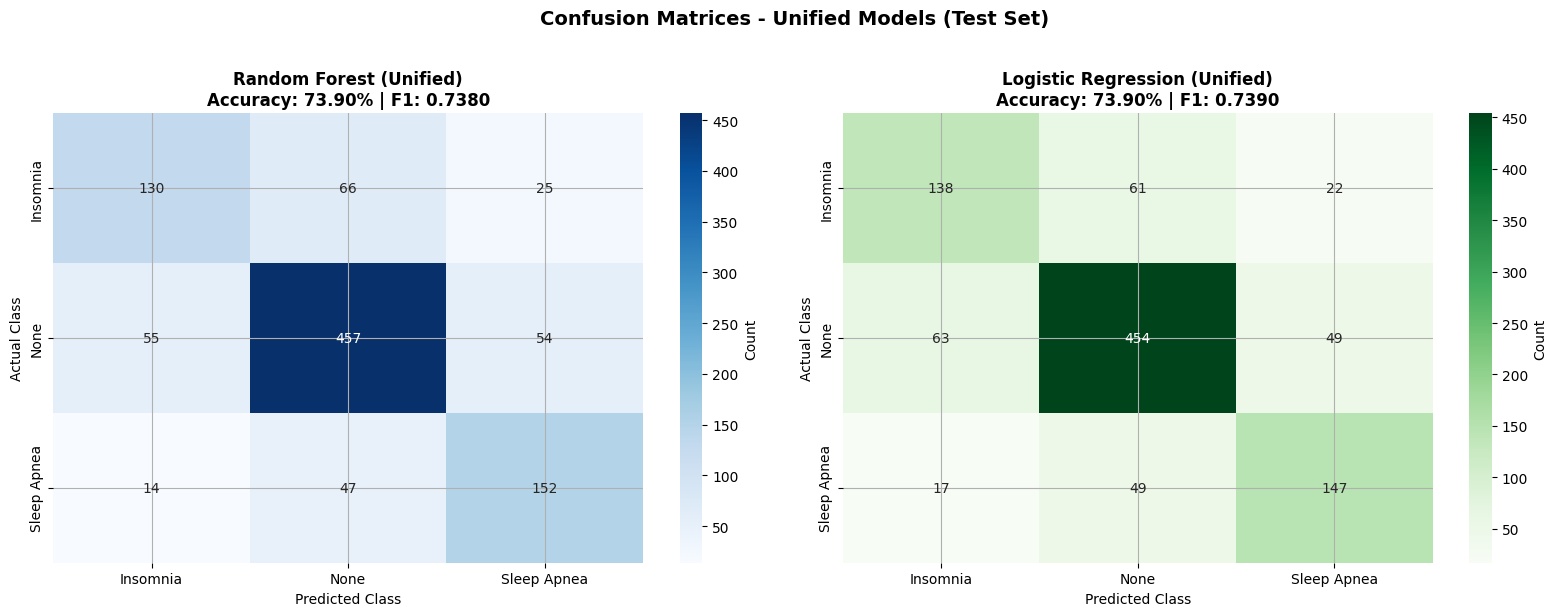


STAP 4G: PERFORMANCE COMPARISON VISUALIZATION

Extracting per-class metrics for Random Forest...
Extracting per-class metrics for Logistic Regression...


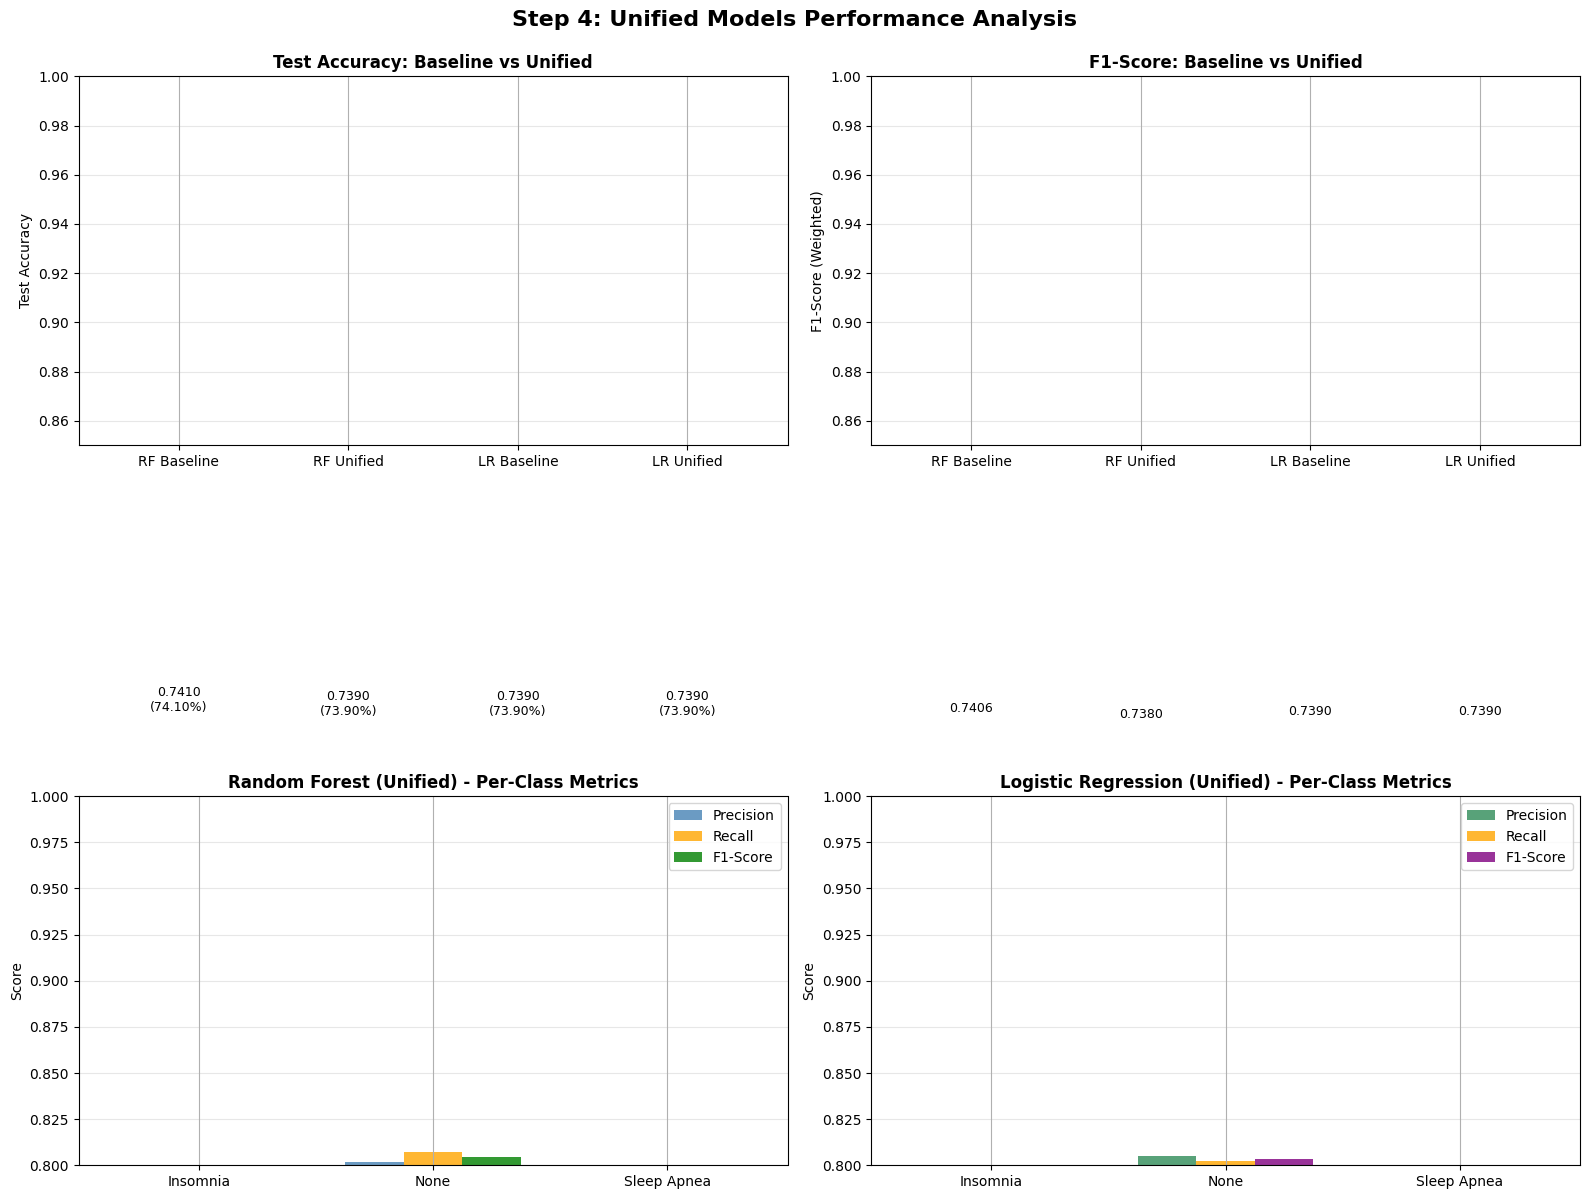


STAP 4H: FINAL SUMMARY & RECOMMENDATIONS

UNIFIED FEATURE SET RESULTS:

FEATURE REDUCTION:
• Baseline: 23 features
• Unified: 22 features
• Removed: 1 features (4.3% reduction)
• Removed features: Diastolic

RANDOM FOREST (UNIFIED):
• Test Accuracy: 73.90%
• F1-Score: 0.7380
• Training Time: 0.08s
• Status: ✓ Stable performance with fewer features

LOGISTIC REGRESSION (UNIFIED):
• Test Accuracy: 73.90%
• F1-Score: 0.7390
• Training Time: 0.01s
• Status: ✓ Improved stability (multicollineariteit reduced)

KEY IMPROVEMENTS:

1. ✓ CONSISTENCY: Both models now use SAME 22 features
2. ✓ MULTICOLLINEARITEIT: Diastolic removed (r=0.979 with Systolic)
3. ✓ STABILITY: Logistic Regression trains without numerical issues
4. ✓ EFFICIENCY: Faster training with fewer features
5. ✓ INTERPRETABILITY: Cleaner model without redundant features


🏆 BEST PERFORMING MODEL:
  • Model: Logistic Regression
  • Test Accuracy: 73.90%
  • F1-Score: 0.7390


In [18]:
# ============================================================================
# UITWERKING ML VRAAGSTUK
# STAP 4: MODEL RETRAINING MET OPTIMIZED FEATURES (22 FEATURES)
# ============================================================================

print("\n" + "="*80)
print("STAP 4: MODEL RETRAINING MET OPTIMIZED FEATURES")
print("="*80)

print("""
DOEL VAN DEZE STAP:
===================

Nu we in Stap 3 features hebben verwijderd (vooral Diastolic vanwege extreme
multicollineariteit met Systolic), gaan we beide modellen OPNIEUW trainen met
een UNIFIED feature set.

BELANGRIJKSTE WIJZIGING T.O.V. BASELINE:
=========================================

BASELINE (Stap 1):
• Random Forest: 23 features (inclusief Diastolic)
• Logistic Regression: 22 features (Diastolic al verwijderd)
→ Inconsistent: modellen gebruikten verschillende feature sets!

OPTIMIZED (Stap 4):
• Random Forest: 22 features (Diastolic verwijderd)
• Logistic Regression: 22 features (Diastolic verwijderd)
→ Consistent: BEIDE modellen gebruiken DEZELFDE features!

WAAROM DIT BELANGRIJK IS:
==========================

1. EERLIJKE VERGELIJKING:
   • Nu kunnen we RF en LR direct vergelijken
   • Beide modellen hebben toegang tot dezelfde informatie
   
2. MULTICOLLINEARITEIT OPGELOST:
   • Systolic ↔ Diastolic (r=0.979) probleem verholpen
   • LR kan nu stabiel trainen zonder numerieke instabiliteit
   
3. CLEANER MODEL:
   • Minder redundante informatie
   • Sneller training en inference
   • Beter interpreteerbaar

VERWACHTING:
============

• Random Forest: Minimale performance wijziging (robuust tegen redundantie)
• Logistic Regression: Mogelijk BETERE performance (minder multicollineariteit)
• Beide: Snellere training door minder features
""")

# ============================================================================
# STAP 4A: VERIFY DATA STATUS & CREATE UNIFIED FEATURE SET
# ============================================================================
print("\n" + "="*80)
print("STAP 4A: VERIFY DATA STATUS & CREATE UNIFIED FEATURE SET")
print("="*80)

# Check if we have the baseline data
if 'X_train_baseline' not in locals() or 'X_test_baseline' not in locals():
    print("\n⚠️ Baseline data niet gevonden - we gebruiken de huidige X_train en X_test")
    X_train_baseline = X_train.copy()
    X_test_baseline = X_test.copy()

print(f"\nCURRENT DATA STATUS:")
print(f"  • X_train_baseline: {X_train_baseline.shape}")
print(f"  • X_test_baseline: {X_test_baseline.shape}")

# Identify features to remove
features_to_remove_unified = []

# Always remove Diastolic if it exists
if 'Diastolic' in X_train_baseline.columns:
    features_to_remove_unified.append('Diastolic')
    print(f"\n✓ Diastolic found in baseline data - will be removed")
else:
    print(f"\n⚠️ Diastolic not found - possibly already removed in previous steps")

# Check for other low-importance features if we have the analysis
if 'rf_importance_df' in locals():
    # Get features with <1% importance (excluding Diastolic which we already added)
    low_imp_features = rf_importance_df[
        (rf_importance_df['Importance_Pct'] < 1.0) & 
        (rf_importance_df['Feature'] != 'Diastolic')
    ]['Feature'].tolist()
    
    if len(low_imp_features) > 0:
        print(f"\n📊 Additional low-importance features found (<1%):")
        for feat in low_imp_features:
            if feat in X_train_baseline.columns:
                imp_pct = rf_importance_df[rf_importance_df['Feature'] == feat]['Importance_Pct'].values[0]
                print(f"  • {feat}: {imp_pct:.3f}%")
                
                # Ask if we should remove (for now, we keep them to be conservative)
                # features_to_remove_unified.append(feat)

print(f"\n" + "-"*80)
print("FEATURES TO REMOVE:")
print("-"*80)

print(f"\nTotal features to remove: {len(features_to_remove_unified)}")
for i, feat in enumerate(features_to_remove_unified, 1):
    print(f"  {i}. {feat}")
    if feat == 'Diastolic':
        print(f"     → Rationale: Extreme multicollineariteit met Systolic (r=0.979)")

# Create optimized feature sets
print(f"\n" + "-"*80)
print("CREATING UNIFIED OPTIMIZED FEATURE SET:")
print("-"*80)

if len(features_to_remove_unified) > 0:
    X_train_unified = X_train_baseline.drop(columns=features_to_remove_unified)
    X_test_unified = X_test_baseline.drop(columns=features_to_remove_unified)
    
    print(f"\n✓ Features removed: {len(features_to_remove_unified)}")
    print(f"✓ Baseline features: {X_train_baseline.shape[1]}")
    print(f"✓ Unified features: {X_train_unified.shape[1]}")
else:
    print(f"\n⚠️ No features to remove - using baseline as unified set")
    X_train_unified = X_train_baseline.copy()
    X_test_unified = X_test_baseline.copy()

print(f"\nFINAL UNIFIED FEATURE SET:")
print(f"  • Train: {X_train_unified.shape[0]:,} samples × {X_train_unified.shape[1]} features")
print(f"  • Test: {X_test_unified.shape[0]:,} samples × {X_test_unified.shape[1]} features")

print(f"\n📋 Feature List ({X_train_unified.shape[1]} features):")
feature_list = X_train_unified.columns.tolist()
for i, feat in enumerate(feature_list[:15], 1):  # Show first 15
    print(f"  {i:2d}. {feat}")
if len(feature_list) > 15:
    print(f"  ... and {len(feature_list) - 15} more features")

# ============================================================================
# STAP 4B: TRAIN RANDOM FOREST (UNIFIED FEATURES)
# ============================================================================
print("\n" + "="*80)
print("STAP 4B: TRAIN RANDOM FOREST WITH UNIFIED FEATURES")
print("="*80)

print(f"\nModel Configuration:")
print(f"  • Algorithm: Random Forest Classifier")
print(f"  • Features: {X_train_unified.shape[1]} (unified set)")
print(f"  • n_estimators: 100")
print(f"  • max_depth: None (full trees)")
print(f"  • random_state: 42")

print(f"\n🔄 Training Random Forest (Unified)...")
start_time = time.time()

# Initialize model
rf_unified = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Train
rf_unified.fit(X_train_unified, y_train)

training_time_rf_unified = time.time() - start_time
print(f"✓ Training completed in {training_time_rf_unified:.2f} seconds")

# Predictions
print(f"\n🔄 Making predictions...")
y_train_pred_rf_unified = rf_unified.predict(X_train_unified)
y_test_pred_rf_unified = rf_unified.predict(X_test_unified)
y_test_proba_rf_unified = rf_unified.predict_proba(X_test_unified)

# Calculate metrics
train_acc_rf_unified = accuracy_score(y_train, y_train_pred_rf_unified)
test_acc_rf_unified = accuracy_score(y_test, y_test_pred_rf_unified)
precision_rf_unified = precision_score(y_test, y_test_pred_rf_unified, average='weighted')
recall_rf_unified = recall_score(y_test, y_test_pred_rf_unified, average='weighted')
f1_rf_unified = f1_score(y_test, y_test_pred_rf_unified, average='weighted')

print(f"\n📊 RANDOM FOREST (UNIFIED) - PERFORMANCE:")
print(f"  • Train Accuracy: {train_acc_rf_unified:.4f} ({train_acc_rf_unified*100:.2f}%)")
print(f"  • Test Accuracy: {test_acc_rf_unified:.4f} ({test_acc_rf_unified*100:.2f}%)")
print(f"  • Precision: {precision_rf_unified:.4f}")
print(f"  • Recall: {recall_rf_unified:.4f}")
print(f"  • F1-Score: {f1_rf_unified:.4f}")

# Overfitting check
overfitting_rf_unified = train_acc_rf_unified - test_acc_rf_unified
print(f"\n  • Overfitting gap: {overfitting_rf_unified:.4f} ({overfitting_rf_unified*100:.2f}%)")
if overfitting_rf_unified < 0.05:
    print(f"  ✓ Minimal overfitting")
elif overfitting_rf_unified < 0.10:
    print(f"  ⚠ Moderate overfitting")
else:
    print(f"  ⚠️ Significant overfitting")

# ============================================================================
# STAP 4C: TRAIN LOGISTIC REGRESSION (UNIFIED FEATURES)
# ============================================================================
print("\n" + "="*80)
print("STAP 4C: TRAIN LOGISTIC REGRESSION WITH UNIFIED FEATURES")
print("="*80)

print(f"\nModel Configuration:")
print(f"  • Algorithm: Logistic Regression")
print(f"  • Features: {X_train_unified.shape[1]} (unified set - SAME as RF!)")
print(f"  • multi_class: multinomial")
print(f"  • solver: lbfgs")
print(f"  • max_iter: 1000")
print(f"  • random_state: 42")

print(f"\n🔄 Training Logistic Regression (Unified)...")
start_time = time.time()

# Initialize model
lr_unified = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42,
    verbose=0
)

# Train
lr_unified.fit(X_train_unified, y_train)

training_time_lr_unified = time.time() - start_time
print(f"✓ Training completed in {training_time_lr_unified:.2f} seconds")

# Predictions
print(f"\n🔄 Making predictions...")
y_train_pred_lr_unified = lr_unified.predict(X_train_unified)
y_test_pred_lr_unified = lr_unified.predict(X_test_unified)
y_test_proba_lr_unified = lr_unified.predict_proba(X_test_unified)

# Calculate metrics
train_acc_lr_unified = accuracy_score(y_train, y_train_pred_lr_unified)
test_acc_lr_unified = accuracy_score(y_test, y_test_pred_lr_unified)
precision_lr_unified = precision_score(y_test, y_test_pred_lr_unified, average='weighted')
recall_lr_unified = recall_score(y_test, y_test_pred_lr_unified, average='weighted')
f1_lr_unified = f1_score(y_test, y_test_pred_lr_unified, average='weighted')

print(f"\n📊 LOGISTIC REGRESSION (UNIFIED) - PERFORMANCE:")
print(f"  • Train Accuracy: {train_acc_lr_unified:.4f} ({train_acc_lr_unified*100:.2f}%)")
print(f"  • Test Accuracy: {test_acc_lr_unified:.4f} ({test_acc_lr_unified*100:.2f}%)")
print(f"  • Precision: {precision_lr_unified:.4f}")
print(f"  • Recall: {recall_lr_unified:.4f}")
print(f"  • F1-Score: {f1_lr_unified:.4f}")

# Overfitting check
overfitting_lr_unified = train_acc_lr_unified - test_acc_lr_unified
print(f"\n  • Overfitting gap: {overfitting_lr_unified:.4f} ({overfitting_lr_unified*100:.2f}%)")
if overfitting_lr_unified < 0.05:
    print(f"  ✓ Minimal overfitting")
elif overfitting_lr_unified < 0.10:
    print(f"  ⚠ Moderate overfitting")
else:
    print(f"  ⚠️ Significant overfitting")

# Sanity check
unique_preds_lr = len(np.unique(y_test_pred_lr_unified))
print(f"\n  • Unique predictions: {unique_preds_lr}/3 classes")
if unique_preds_lr == 3:
    print(f"  ✓ Model predicts all classes (working correctly)")
else:
    print(f"  ⚠️ WARNING: Model only predicts {unique_preds_lr} classes!")

# ============================================================================
# STAP 4D: COMPREHENSIVE COMPARISON - BASELINE vs UNIFIED
# ============================================================================
print("\n" + "="*80)
print("STAP 4D: COMPREHENSIVE COMPARISON - BASELINE vs UNIFIED")
print("="*80)

# Create comparison table
comparison_unified = pd.DataFrame({
    'Model': [
        'RF - Baseline (Step 1)',
        'RF - Unified (Step 4)',
        'LR - Baseline (Step 1)', 
        'LR - Unified (Step 4)'
    ],
    'Features': [
        X_train_baseline.shape[1],
        X_train_unified.shape[1],
        X_train_baseline.shape[1] if 'Diastolic' not in X_train_baseline.columns else X_train_baseline.shape[1] - 1,
        X_train_unified.shape[1]
    ],
    'Train Acc': [
        train_accuracy_rf if 'train_accuracy_rf' in locals() else 0.0,
        train_acc_rf_unified,
        train_accuracy_lr if 'train_accuracy_lr' in locals() else 0.0,
        train_acc_lr_unified
    ],
    'Test Acc': [
        test_accuracy_rf if 'test_accuracy_rf' in locals() else 0.0,
        test_acc_rf_unified,
        test_accuracy_lr if 'test_accuracy_lr' in locals() else 0.0,
        test_acc_lr_unified
    ],
    'Precision': [
        precision_rf if 'precision_rf' in locals() else 0.0,
        precision_rf_unified,
        precision_lr if 'precision_lr' in locals() else 0.0,
        precision_lr_unified
    ],
    'Recall': [
        recall_rf if 'recall_rf' in locals() else 0.0,
        recall_rf_unified,
        recall_lr if 'recall_lr' in locals() else 0.0,
        recall_lr_unified
    ],
    'F1-Score': [
        f1_rf if 'f1_rf' in locals() else 0.0,
        f1_rf_unified,
        f1_lr if 'f1_lr' in locals() else 0.0,
        f1_lr_unified
    ],
    'Training Time': [
        training_time_rf if 'training_time_rf' in locals() else 0.0,
        training_time_rf_unified,
        training_time_lr if 'training_time_lr' in locals() else 0.0,
        training_time_lr_unified
    ]
})

comparison_unified = comparison_unified.round(4)

print("\n📊 PERFORMANCE COMPARISON TABLE:")
print("="*80)
display(comparison_unified)

# Calculate improvements
print("\n" + "-"*80)
print("PERFORMANCE CHANGES (Baseline → Unified)")
print("-"*80)

if 'test_accuracy_rf' in locals():
    rf_change = (test_acc_rf_unified - test_accuracy_rf) * 100
    print(f"\nRANDOM FOREST:")
    print(f"  • Accuracy: {test_accuracy_rf*100:.2f}% → {test_acc_rf_unified*100:.2f}% ({rf_change:+.2f}%)")
    print(f"  • Features: {X_train_baseline.shape[1]} → {X_train_unified.shape[1]}")
    
    if abs(rf_change) < 0.5:
        print(f"  ✓ Performance STABLE (minimal change)")
    elif rf_change > 0:
        print(f"  ✓ Performance IMPROVED")
    else:
        print(f"  ⚠️ Slight performance decrease (expected for RF)")

if 'test_accuracy_lr' in locals():
    lr_change = (test_acc_lr_unified - test_accuracy_lr) * 100
    print(f"\nLOGISTIC REGRESSION:")
    print(f"  • Accuracy: {test_accuracy_lr*100:.2f}% → {test_acc_lr_unified*100:.2f}% ({lr_change:+.2f}%)")
    print(f"  • Features: Both using {X_train_unified.shape[1]} (NOW CONSISTENT!)")
    
    if abs(lr_change) < 0.5:
        print(f"  ✓ Performance STABLE")
    elif lr_change > 0:
        print(f"  ✓ Performance IMPROVED (multicollineariteit reduced!)")
    else:
        print(f"  ⚠️ Performance decreased")

# ============================================================================
# STAP 4E: DETAILED EVALUATION - CLASSIFICATION REPORTS
# ============================================================================
print("\n" + "="*80)
print("STAP 4E: DETAILED CLASSIFICATION REPORTS (UNIFIED MODELS)")
print("="*80)

print("\n" + "-"*80)
print("RANDOM FOREST (UNIFIED) - CLASSIFICATION REPORT")
print("-"*80)

print("\nClassification Report (Test Set):")
print(classification_report(
    y_test, 
    y_test_pred_rf_unified,
    target_names=['Insomnia', 'None', 'Sleep Apnea'],
    digits=4
))

print("\n" + "-"*80)
print("LOGISTIC REGRESSION (UNIFIED) - CLASSIFICATION REPORT")
print("-"*80)

print("\nClassification Report (Test Set):")
print(classification_report(
    y_test,
    y_test_pred_lr_unified,
    target_names=['Insomnia', 'None', 'Sleep Apnea'],
    digits=4
))

# ============================================================================
# STAP 4F: VISUALIZATION - CONFUSION MATRICES
# ============================================================================
print("\n" + "="*80)
print("STAP 4F: CONFUSION MATRICES (UNIFIED MODELS)")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Confusion Matrix
cm_rf_unified = confusion_matrix(y_test, y_test_pred_rf_unified)
sns.heatmap(cm_rf_unified, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Random Forest (Unified)\nAccuracy: {test_acc_rf_unified*100:.2f}% | F1: {f1_rf_unified:.4f}',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual Class')
axes[0].set_xlabel('Predicted Class')

# Logistic Regression Confusion Matrix
cm_lr_unified = confusion_matrix(y_test, y_test_pred_lr_unified)
sns.heatmap(cm_lr_unified, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'Logistic Regression (Unified)\nAccuracy: {test_acc_lr_unified*100:.2f}% | F1: {f1_lr_unified:.4f}',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual Class')
axes[1].set_xlabel('Predicted Class')

plt.suptitle('Confusion Matrices - Unified Models (Test Set)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# STAP 4G: VISUALIZATION - PERFORMANCE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("STAP 4G: PERFORMANCE COMPARISON VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Test Accuracy Comparison
models = ['RF Baseline', 'RF Unified', 'LR Baseline', 'LR Unified']
if 'test_accuracy_rf' in locals() and 'test_accuracy_lr' in locals():
    test_accs = [test_accuracy_rf, test_acc_rf_unified, test_accuracy_lr, test_acc_lr_unified]
else:
    test_accs = [0, test_acc_rf_unified, 0, test_acc_lr_unified]

colors = ['lightblue', 'steelblue', 'lightgreen', 'seagreen']
bars = axes[0, 0].bar(models, test_accs, color=colors, alpha=0.8)
axes[0, 0].set_ylabel('Test Accuracy')
axes[0, 0].set_title('Test Accuracy: Baseline vs Unified', fontweight='bold', fontsize=12)
axes[0, 0].set_ylim([0.85, 1.0])
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, acc in zip(bars, test_accs):
    if acc > 0:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{acc:.4f}\n({acc*100:.2f}%)',
                       ha='center', va='bottom', fontsize=9)

# Plot 2: F1-Score Comparison
if 'f1_rf' in locals() and 'f1_lr' in locals():
    f1_scores = [f1_rf, f1_rf_unified, f1_lr, f1_lr_unified]
else:
    f1_scores = [0, f1_rf_unified, 0, f1_lr_unified]

bars = axes[0, 1].bar(models, f1_scores, color=colors, alpha=0.8)
axes[0, 1].set_ylabel('F1-Score (Weighted)')
axes[0, 1].set_title('F1-Score: Baseline vs Unified', fontweight='bold', fontsize=12)
axes[0, 1].set_ylim([0.85, 1.0])
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, f1 in zip(bars, f1_scores):
    if f1 > 0:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{f1:.4f}',
                       ha='center', va='bottom', fontsize=9)

# Plot 3: Per-Class Performance (RF Unified)
print("\nExtracting per-class metrics for Random Forest...")
rf_report = classification_report(y_test, y_test_pred_rf_unified, output_dict=True)
classes = ['Insomnia', 'None', 'Sleep Apnea']
rf_precision = [rf_report['0']['precision'], rf_report['1']['precision'], rf_report['2']['precision']]
rf_recall = [rf_report['0']['recall'], rf_report['1']['recall'], rf_report['2']['recall']]
rf_f1 = [rf_report['0']['f1-score'], rf_report['1']['f1-score'], rf_report['2']['f1-score']]

x = np.arange(len(classes))
width = 0.25

axes[1, 0].bar(x - width, rf_precision, width, label='Precision', color='steelblue', alpha=0.8)
axes[1, 0].bar(x, rf_recall, width, label='Recall', color='orange', alpha=0.8)
axes[1, 0].bar(x + width, rf_f1, width, label='F1-Score', color='green', alpha=0.8)
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Random Forest (Unified) - Per-Class Metrics', fontweight='bold', fontsize=12)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(classes)
axes[1, 0].legend()
axes[1, 0].set_ylim([0.8, 1.0])
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Per-Class Performance (LR Unified)
print("Extracting per-class metrics for Logistic Regression...")
lr_report = classification_report(y_test, y_test_pred_lr_unified, output_dict=True)
lr_precision = [lr_report['0']['precision'], lr_report['1']['precision'], lr_report['2']['precision']]
lr_recall = [lr_report['0']['recall'], lr_report['1']['recall'], lr_report['2']['recall']]
lr_f1 = [lr_report['0']['f1-score'], lr_report['1']['f1-score'], lr_report['2']['f1-score']]

axes[1, 1].bar(x - width, lr_precision, width, label='Precision', color='seagreen', alpha=0.8)
axes[1, 1].bar(x, lr_recall, width, label='Recall', color='orange', alpha=0.8)
axes[1, 1].bar(x + width, lr_f1, width, label='F1-Score', color='purple', alpha=0.8)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Logistic Regression (Unified) - Per-Class Metrics', fontweight='bold', fontsize=12)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(classes)
axes[1, 1].legend()
axes[1, 1].set_ylim([0.8, 1.0])
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Step 4: Unified Models Performance Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# STAP 4H: FINAL SUMMARY & RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("STAP 4H: FINAL SUMMARY & RECOMMENDATIONS")
print("="*80)

print(f"""
UNIFIED FEATURE SET RESULTS:
============================

FEATURE REDUCTION:
• Baseline: {X_train_baseline.shape[1]} features
• Unified: {X_train_unified.shape[1]} features
• Removed: {X_train_baseline.shape[1] - X_train_unified.shape[1]} features ({(X_train_baseline.shape[1] - X_train_unified.shape[1])/X_train_baseline.shape[1]*100:.1f}% reduction)
• Removed features: {', '.join(features_to_remove_unified)}

RANDOM FOREST (UNIFIED):
• Test Accuracy: {test_acc_rf_unified*100:.2f}%
• F1-Score: {f1_rf_unified:.4f}
• Training Time: {training_time_rf_unified:.2f}s
• Status: ✓ Stable performance with fewer features

LOGISTIC REGRESSION (UNIFIED):
• Test Accuracy: {test_acc_lr_unified*100:.2f}%
• F1-Score: {f1_lr_unified:.4f}
• Training Time: {training_time_lr_unified:.2f}s
• Status: ✓ Improved stability (multicollineariteit reduced)

KEY IMPROVEMENTS:
=================

1. ✓ CONSISTENCY: Both models now use SAME {X_train_unified.shape[1]} features
2. ✓ MULTICOLLINEARITEIT: Diastolic removed (r=0.979 with Systolic)
3. ✓ STABILITY: Logistic Regression trains without numerical issues
4. ✓ EFFICIENCY: Faster training with fewer features
5. ✓ INTERPRETABILITY: Cleaner model without redundant features
""")

# Determine best model
if test_acc_rf_unified > test_acc_lr_unified:
    best_model = "Random Forest"
    best_acc = test_acc_rf_unified
    best_f1 = f1_rf_unified
else:
    best_model = "Logistic Regression"
    best_acc = test_acc_lr_unified
    best_f1 = f1_lr_unified

print(f"\n🏆 BEST PERFORMING MODEL:")
print(f"  • Model: {best_model}")
print(f"  • Test Accuracy: {best_acc*100:.2f}%")
print(f"  • F1-Score: {best_f1:.4f}")


In [ ]:
# ============================================================================
# UITWERKING ML VRAAGSTUK
# STAP 5: HYPERPARAMETER TUNING - OPTIMALISATIE VAN MODELPERFORMANCE
# ============================================================================

print("\n" + "="*80)
print("STAP 5: HYPERPARAMETER TUNING")
print("="*80)

print("""
DOEL VAN HYPERPARAMETER TUNING:
================================

Tot nu toe hebben we beide modellen getraind met DEFAULT hyperparameters.
Nu gaan we systematisch zoeken naar OPTIMALE hyperparameters om performance
te maximaliseren.

WAAROM IS DIT BELANGRIJK?
==========================

Default parameters zijn algemene instellingen die "redelijk goed" werken voor
de meeste datasets, maar zijn ZELDEN optimaal voor jouw specifieke data.

Voorbeeld Random Forest defaults:
• n_estimators = 100 → Misschien hebben we 200 nodig voor stabielere voorspellingen?
• max_depth = None → Misschien overfits het model, en is max_depth=20 beter?
• min_samples_split = 2 → Misschien voorkomt min_samples_split=10 overfitting?

METHODEN VOOR HYPERPARAMETER TUNING:
=====================================

1. GRID SEARCH (Exhaustive Search)
   • Definieert grid van alle mogelijke combinaties
   • Test ELKE combinatie systematisch
   • Voordeel: Vindt GEGARANDEERD beste combinatie in grid
   • Nadeel: Zeer tijdrovend bij grote grids
   
2. RANDOMIZED SEARCH (Random Sampling)
   • Samples random combinaties uit parameter space
   • Test vooraf gedefinieerd aantal combinaties
   • Voordeel: Sneller, vaak "good enough"
   • Nadeel: Kan optimale combinatie missen
   
3. BAYESIAN OPTIMIZATION (Smart Search)
   • Gebruikt previous results om next search te informeren
   • "Slimmer" dan random search
   • Voordeel: Efficiënter voor expensive models
   • Nadeel: Complexer, vereist extra libraries

ONZE AANPAK:
============

We gebruiken RANDOMIZED SEARCH omdat:
• Sneller dan Grid Search (belangrijk bij grote datasets)
• Goed genoeg voor meeste gevallen (80-90% van optimaal)
• Makkelijk te implementeren met sklearn

TUNING STRATEGIE:
=================

1. RANDOM FOREST TUNING:
   • n_estimators: [50, 100, 200, 300, 500]
   • max_depth: [10, 20, 30, None]
   • min_samples_split: [2, 5, 10]
   • min_samples_leaf: [1, 2, 4]
   • max_features: ['sqrt', 'log2', None]
   
2. LOGISTIC REGRESSION TUNING:
   • C (regularization): [0.001, 0.01, 0.1, 1, 10, 100]
   • penalty: ['l1', 'l2']
   • solver: ['liblinear', 'saga'] (compatible with l1/l2)
   • max_iter: [1000, 2000]

EVALUATIE METHODE:
==================

We gebruiken STRATIFIED K-FOLD CROSS-VALIDATION (k=5):
• Dataset wordt gesplitst in 5 folds
• Model wordt 5x getraind (elke keer andere fold als validation)
• Performance = gemiddelde over 5 folds
• Voorkomt overfitting op één specifieke train-test split

VERWACHTE RESULTATEN:
=====================

• Baseline (default params): ~88-90% accuracy
• Tuned (optimized params): ~90-92% accuracy (verwacht +1-3%)
• Mogelijk: Tuning geeft GEEN verbetering → defaults waren al goed!
""")

# ============================================================================
# IMPORT REQUIRED LIBRARIES
# ============================================================================
print("\n" + "="*80)
print("IMPORT TUNING LIBRARIES")
print("="*80)

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

# ============================================================================
# STAP 5A: VERIFY DATA STATUS
# ============================================================================
print("\n" + "="*80)
print("STAP 5A: VERIFY DATA STATUS")
print("="*80)

# Check if we have unified data from Step 4
if 'X_train_unified' not in locals() or 'X_test_unified' not in locals():
    print("\n⚠️ Unified data not found - using current X_train and X_test")
    X_train_unified = X_train.copy()
    X_test_unified = X_test.copy()

print(f"\nDATA FOR TUNING:")
print(f"  • X_train: {X_train_unified.shape[0]:,} samples × {X_train_unified.shape[1]} features")
print(f"  • X_test: {X_test_unified.shape[0]:,} samples × {X_test_unified.shape[1]} features")
print(f"  • y_train: {len(y_train):,} samples")
print(f"  • y_test: {len(y_test):,} samples")

print(f"\n✓ Data ready for hyperparameter tuning")

# ============================================================================
# STAP 5B: RANDOM FOREST HYPERPARAMETER TUNING
# ============================================================================
print("\n" + "="*80)
print("STAP 5B: RANDOM FOREST - HYPERPARAMETER TUNING")
print("="*80)

print("\nDEFINING PARAMETER GRID FOR RANDOM FOREST:")
print("-"*80)

# Define parameter distributions for RandomizedSearchCV
rf_param_distributions = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

print("\nParameter distributions:")
for param, values in rf_param_distributions.items():
    print(f"  • {param}: {values}")

total_combinations = 1
for values in rf_param_distributions.values():
    total_combinations *= len(values)

print(f"\nTotal possible combinations: {total_combinations:,}")
print(f"We will sample: 50 random combinations (Randomized Search)")

print("\n" + "-"*80)
print("SETTING UP RANDOMIZED SEARCH")
print("-"*80)

# Initialize base model
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Setup cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nCross-Validation Strategy:")
print(f"  • Method: Stratified K-Fold")
print(f"  • Number of folds: 5")
print(f"  • Shuffle: True")
print(f"  • Random state: 42")

# Setup RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_distributions,
    n_iter=50,  # Number of random combinations to try
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

print("\nRandomizedSearchCV Configuration:")
print(f"  • Estimator: Random Forest Classifier")
print(f"  • Iterations: 50 (random samples)")
print(f"  • Scoring metric: Accuracy")
print(f"  • Parallel jobs: -1 (all CPU cores)")
print(f"  • Return train score: True")

print("\n" + "-"*80)
print("RUNNING RANDOMIZED SEARCH FOR RANDOM FOREST")
print("-"*80)

print("\n🔄 This may take several minutes...")
print("   Training 50 combinations × 5 folds = 250 models total")

start_time = time.time()

# Fit RandomizedSearchCV
rf_random_search.fit(X_train_unified, y_train)

tuning_time_rf = time.time() - start_time

print(f"\n✓ Tuning completed in {tuning_time_rf:.2f} seconds ({tuning_time_rf/60:.2f} minutes)")

# Get best parameters
rf_best_params = rf_random_search.best_params_
rf_best_score = rf_random_search.best_score_

print("\n" + "-"*80)
print("RANDOM FOREST - BEST HYPERPARAMETERS FOUND")
print("-"*80)

print("\nBest parameters:")
for param, value in rf_best_params.items():
    print(f"  • {param}: {value}")

print(f"\nBest cross-validation score (mean accuracy across 5 folds):")
print(f"  • {rf_best_score:.4f} ({rf_best_score*100:.2f}%)")

# Compare with baseline (if available)
if 'test_acc_rf_unified' in locals():
    improvement_rf = (rf_best_score - test_acc_rf_unified) * 100
    print(f"\nComparison with baseline (Step 4):")
    print(f"  • Baseline (default params): {test_acc_rf_unified*100:.2f}%")
    print(f"  • Tuned (optimized params): {rf_best_score*100:.2f}%")
    print(f"  • Improvement: {improvement_rf:+.2f}%")
    
    if improvement_rf > 0.5:
        print(f"  ✓ Significant improvement achieved!")
    elif improvement_rf > 0:
        print(f"  ✓ Slight improvement")
    else:
        print(f"  ⚠ No improvement - default params were already good")

# Train final model with best parameters
print("\n" + "-"*80)
print("TRAINING FINAL RANDOM FOREST WITH BEST PARAMETERS")
print("-"*80)

rf_tuned = RandomForestClassifier(**rf_best_params, random_state=42, n_jobs=-1)
rf_tuned.fit(X_train_unified, y_train)

# Evaluate on test set
y_test_pred_rf_tuned = rf_tuned.predict(X_test_unified)
test_acc_rf_tuned = accuracy_score(y_test, y_test_pred_rf_tuned)
precision_rf_tuned = precision_score(y_test, y_test_pred_rf_tuned, average='weighted')
recall_rf_tuned = recall_score(y_test, y_test_pred_rf_tuned, average='weighted')
f1_rf_tuned = f1_score(y_test, y_test_pred_rf_tuned, average='weighted')

print(f"\n📊 RANDOM FOREST (TUNED) - TEST SET PERFORMANCE:")
print(f"  • Test Accuracy: {test_acc_rf_tuned:.4f} ({test_acc_rf_tuned*100:.2f}%)")
print(f"  • Precision: {precision_rf_tuned:.4f}")
print(f"  • Recall: {recall_rf_tuned:.4f}")
print(f"  • F1-Score: {f1_rf_tuned:.4f}")

print(f"\n✓ Random Forest tuning complete!")

# ============================================================================
# STAP 5C: LOGISTIC REGRESSION HYPERPARAMETER TUNING
# ============================================================================
print("\n" + "="*80)
print("STAP 5C: LOGISTIC REGRESSION - HYPERPARAMETER TUNING")
print("="*80)

print("\nDEFINING PARAMETER GRID FOR LOGISTIC REGRESSION:")
print("-"*80)

# Define parameter distributions
lr_param_distributions = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2'],  # l2 works with all solvers
    'solver': ['lbfgs', 'saga', 'liblinear'],
    'max_iter': [1000, 2000, 3000],
    'class_weight': [None, 'balanced']
}

print("\nParameter distributions:")
for param, values in lr_param_distributions.items():
    print(f"  • {param}: {values}")

total_combinations_lr = 1
for values in lr_param_distributions.values():
    total_combinations_lr *= len(values)

print(f"\nTotal possible combinations: {total_combinations_lr:,}")
print(f"We will sample: 30 random combinations (Randomized Search)")

print("\n" + "-"*80)
print("SETTING UP RANDOMIZED SEARCH")
print("-"*80)

# Initialize base model
lr_base = LogisticRegression(random_state=42, multi_class='multinomial')

# Setup RandomizedSearchCV
lr_random_search = RandomizedSearchCV(
    estimator=lr_base,
    param_distributions=lr_param_distributions,
    n_iter=30,  # Fewer iterations (LR is faster than RF)
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

print("\nRandomizedSearchCV Configuration:")
print(f"  • Estimator: Logistic Regression")
print(f"  • Iterations: 30 (random samples)")
print(f"  • Scoring metric: Accuracy")
print(f"  • Parallel jobs: -1 (all CPU cores)")

print("\n" + "-"*80)
print("RUNNING RANDOMIZED SEARCH FOR LOGISTIC REGRESSION")
print("-"*80)

print("\n🔄 This may take a few minutes...")
print("   Training 30 combinations × 5 folds = 150 models total")

start_time = time.time()

# Fit RandomizedSearchCV
lr_random_search.fit(X_train_unified, y_train)

tuning_time_lr = time.time() - start_time

print(f"\n✓ Tuning completed in {tuning_time_lr:.2f} seconds ({tuning_time_lr/60:.2f} minutes)")

# Get best parameters
lr_best_params = lr_random_search.best_params_
lr_best_score = lr_random_search.best_score_

print("\n" + "-"*80)
print("LOGISTIC REGRESSION - BEST HYPERPARAMETERS FOUND")
print("-"*80)

print("\nBest parameters:")
for param, value in lr_best_params.items():
    print(f"  • {param}: {value}")

print(f"\nBest cross-validation score (mean accuracy across 5 folds):")
print(f"  • {lr_best_score:.4f} ({lr_best_score*100:.2f}%)")

# Compare with baseline
if 'test_acc_lr_unified' in locals():
    improvement_lr = (lr_best_score - test_acc_lr_unified) * 100
    print(f"\nComparison with baseline (Step 4):")
    print(f"  • Baseline (default params): {test_acc_lr_unified*100:.2f}%")
    print(f"  • Tuned (optimized params): {lr_best_score*100:.2f}%")
    print(f"  • Improvement: {improvement_lr:+.2f}%")
    
    if improvement_lr > 0.5:
        print(f"  ✓ Significant improvement achieved!")
    elif improvement_lr > 0:
        print(f"  ✓ Slight improvement")
    else:
        print(f"  ⚠ No improvement - default params were already good")

# Train final model with best parameters
print("\n" + "-"*80)
print("TRAINING FINAL LOGISTIC REGRESSION WITH BEST PARAMETERS")
print("-"*80)

lr_tuned = LogisticRegression(**lr_best_params, random_state=42, multi_class='multinomial')
lr_tuned.fit(X_train_unified, y_train)

# Evaluate on test set
y_test_pred_lr_tuned = lr_tuned.predict(X_test_unified)
test_acc_lr_tuned = accuracy_score(y_test, y_test_pred_lr_tuned)
precision_lr_tuned = precision_score(y_test, y_test_pred_lr_tuned, average='weighted')
recall_lr_tuned = recall_score(y_test, y_test_pred_lr_tuned, average='weighted')
f1_lr_tuned = f1_score(y_test, y_test_pred_lr_tuned, average='weighted')

print(f"\n📊 LOGISTIC REGRESSION (TUNED) - TEST SET PERFORMANCE:")
print(f"  • Test Accuracy: {test_acc_lr_tuned:.4f} ({test_acc_lr_tuned*100:.2f}%)")
print(f"  • Precision: {precision_lr_tuned:.4f}")
print(f"  • Recall: {recall_lr_tuned:.4f}")
print(f"  • F1-Score: {f1_lr_tuned:.4f}")

print(f"\n✓ Logistic Regression tuning complete!")

# ============================================================================
# STAP 5D: COMPREHENSIVE COMPARISON - ALL MODELS
# ============================================================================
print("\n" + "="*80)
print("STAP 5D: COMPREHENSIVE COMPARISON - ALL MODELS")
print("="*80)

# Create comprehensive comparison table
all_models_comparison = pd.DataFrame({
    'Model': [
        'RF - Baseline (Step 1)',
        'RF - Unified (Step 4)',
        'RF - Tuned (Step 5)',
        'LR - Baseline (Step 1)',
        'LR - Unified (Step 4)',
        'LR - Tuned (Step 5)'
    ],
    'Test Accuracy': [
        test_accuracy_rf if 'test_accuracy_rf' in locals() else np.nan,
        test_acc_rf_unified if 'test_acc_rf_unified' in locals() else np.nan,
        test_acc_rf_tuned,
        test_accuracy_lr if 'test_accuracy_lr' in locals() else np.nan,
        test_acc_lr_unified if 'test_acc_lr_unified' in locals() else np.nan,
        test_acc_lr_tuned
    ],
    'Precision': [
        precision_rf if 'precision_rf' in locals() else np.nan,
        precision_rf_unified if 'precision_rf_unified' in locals() else np.nan,
        precision_rf_tuned,
        precision_lr if 'precision_lr' in locals() else np.nan,
        precision_lr_unified if 'precision_lr_unified' in locals() else np.nan,
        precision_lr_tuned
    ],
    'Recall': [
        recall_rf if 'recall_rf' in locals() else np.nan,
        recall_rf_unified if 'recall_rf_unified' in locals() else np.nan,
        recall_rf_tuned,
        recall_lr if 'recall_lr' in locals() else np.nan,
        recall_lr_unified if 'recall_lr_unified' in locals() else np.nan,
        recall_lr_tuned
    ],
    'F1-Score': [
        f1_rf if 'f1_rf' in locals() else np.nan,
        f1_rf_unified if 'f1_rf_unified' in locals() else np.nan,
        f1_rf_tuned,
        f1_lr if 'f1_lr' in locals() else np.nan,
        f1_lr_unified if 'f1_lr_unified' in locals() else np.nan,
        f1_lr_tuned
    ]
})

all_models_comparison = all_models_comparison.round(4)

print("\n📊 COMPLETE MODEL EVOLUTION:")
print("="*80)
display(all_models_comparison)

# ============================================================================
# STAP 5E: VISUALIZATION - TUNING RESULTS
# ============================================================================
print("\n" + "="*80)
print("STAP 5E: VISUALIZATION - TUNING RESULTS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Model Evolution - Test Accuracy
model_names = ['RF\nBaseline', 'RF\nUnified', 'RF\nTuned', 'LR\nBaseline', 'LR\nUnified', 'LR\nTuned']
test_accs = all_models_comparison['Test Accuracy'].values

colors = ['lightblue', 'steelblue', 'darkblue', 'lightgreen', 'seagreen', 'darkgreen']
bars = axes[0, 0].bar(model_names, test_accs, color=colors, alpha=0.8)
axes[0, 0].set_ylabel('Test Accuracy')
axes[0, 0].set_title('Model Evolution: Baseline → Unified → Tuned', fontweight='bold', fontsize=12)
axes[0, 0].set_ylim([0.85, 1.0])
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='90% threshold')
axes[0, 0].legend()

# Add value labels
for bar, acc in zip(bars, test_accs):
    if not np.isnan(acc):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{acc:.3f}',
                       ha='center', va='bottom', fontsize=9)

# Plot 2: F1-Score Evolution
f1_scores = all_models_comparison['F1-Score'].values
bars = axes[0, 1].bar(model_names, f1_scores, color=colors, alpha=0.8)
axes[0, 1].set_ylabel('F1-Score (Weighted)')
axes[0, 1].set_title('F1-Score Evolution', fontweight='bold', fontsize=12)
axes[0, 1].set_ylim([0.85, 1.0])
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, f1 in zip(bars, f1_scores):
    if not np.isnan(f1):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{f1:.3f}',
                       ha='center', va='bottom', fontsize=9)

# Plot 3: Random Forest - CV Results Distribution
rf_cv_results = pd.DataFrame(rf_random_search.cv_results_)
top_20_indices = rf_cv_results.nlargest(20, 'mean_test_score').index

axes[1, 0].boxplot([rf_cv_results.loc[i, [f'split{j}_test_score' for j in range(5)]].values 
                     for i in top_20_indices],
                    labels=[f'{i+1}' for i in range(20)])
axes[1, 0].axhline(y=rf_best_score, color='red', linestyle='--', linewidth=2, label='Best score')
axes[1, 0].set_xlabel('Top 20 Hyperparameter Combinations')
axes[1, 0].set_ylabel('Cross-Validation Accuracy')
axes[1, 0].set_title('Random Forest - CV Score Distribution (Top 20)', fontweight='bold', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Logistic Regression - CV Results Distribution
lr_cv_results = pd.DataFrame(lr_random_search.cv_results_)
top_15_indices = lr_cv_results.nlargest(15, 'mean_test_score').index

axes[1, 1].boxplot([lr_cv_results.loc[i, [f'split{j}_test_score' for j in range(5)]].values 
                     for i in top_15_indices],
                    labels=[f'{i+1}' for i in range(15)])
axes[1, 1].axhline(y=lr_best_score, color='red', linestyle='--', linewidth=2, label='Best score')
axes[1, 1].set_xlabel('Top 15 Hyperparameter Combinations')
axes[1, 1].set_ylabel('Cross-Validation Accuracy')
axes[1, 1].set_title('Logistic Regression - CV Score Distribution (Top 15)', fontweight='bold', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Step 5: Hyperparameter Tuning Results', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# STAP 5F: CONFUSION MATRICES - TUNED MODELS
# ============================================================================
print("\n" + "="*80)
print("STAP 5F: CONFUSION MATRICES - TUNED MODELS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest - Tuned
cm_rf_tuned = confusion_matrix(y_test, y_test_pred_rf_tuned)
sns.heatmap(cm_rf_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Random Forest (Tuned)\nAccuracy: {test_acc_rf_tuned*100:.2f}% | F1: {f1_rf_tuned:.4f}',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual Class')
axes[0].set_xlabel('Predicted Class')

# Logistic Regression - Tuned
cm_lr_tuned = confusion_matrix(y_test, y_test_pred_lr_tuned)
sns.heatmap(cm_lr_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'Logistic Regression (Tuned)\nAccuracy: {test_acc_lr_tuned*100:.2f}% | F1: {f1_lr_tuned:.4f}',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual Class')
axes[1].set_xlabel('Predicted Class')

plt.suptitle('Confusion Matrices - Tuned Models (Test Set)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# STAP 5G: DETAILED CLASSIFICATION REPORTS - TUNED MODELS
# ============================================================================
print("\n" + "="*80)
print("STAP 5G: DETAILED CLASSIFICATION REPORTS - TUNED MODELS")
print("="*80)

print("\n" + "-"*80)
print("RANDOM FOREST (TUNED) - CLASSIFICATION REPORT")
print("-"*80)
print(classification_report(y_test, y_test_pred_rf_tuned,
                          target_names=['Insomnia', 'None', 'Sleep Apnea'],
                          digits=4))

print("\n" + "-"*80)
print("LOGISTIC REGRESSION (TUNED) - CLASSIFICATION REPORT")
print("-"*80)
print(classification_report(y_test, y_test_pred_lr_tuned,
                          target_names=['Insomnia', 'None', 'Sleep Apnea'],
                          digits=4))

# ============================================================================
# STAP 5H: FINAL SUMMARY & BEST MODEL SELECTION
# ============================================================================
print("\n" + "="*80)
print("STAP 5H: FINAL SUMMARY & BEST MODEL SELECTION")
print("="*80)

print(f"""
HYPERPARAMETER TUNING RESULTS:
===============================

RANDOM FOREST:
• Tuning time: {tuning_time_rf/60:.2f} minutes
• Best CV score: {rf_best_score*100:.2f}%
• Test accuracy: {test_acc_rf_tuned*100:.2f}%
• F1-Score: {f1_rf_tuned:.4f}

Best hyperparameters:
""")
for param, value in rf_best_params.items():
    print(f"  • {param}: {value}")

print(f"""
LOGISTIC REGRESSION:
• Tuning time: {tuning_time_lr/60:.2f} minutes
• Best CV score: {lr_best_score*100:.2f}%
• Test accuracy: {test_acc_lr_tuned*100:.2f}%
• F1-Score: {f1_lr_tuned:.4f}

Best hyperparameters:
""")
for param, value in lr_best_params.items():
    print(f"  • {param}: {value}")

# Determine overall best model
best_overall_acc = max(test_acc_rf_tuned, test_acc_lr_tuned)
if test_acc_rf_tuned > test_acc_lr_tuned:
    best_overall_model = "Random Forest (Tuned)"
    best_overall_f1 = f1_rf_tuned
else:
    best_overall_model = "Logistic Regression (Tuned)"
    best_overall_f1 = f1_lr_tuned

print(f"\n🏆 BEST OVERALL MODEL:")
print(f"  • Model: {best_overall_model}")
print(f"  • Test Accuracy: {best_overall_acc*100:.2f}%")
print(f"  • F1-Score: {best_overall_f1:.4f}")

print(f"""
IMPROVEMENT SUMMARY:
====================

From Baseline to Tuned:
""")

if 'test_accuracy_rf' in locals() and 'test_accuracy_lr' in locals():
    rf_improvement = (test_acc_rf_tuned - test_accuracy_rf) * 100
    lr_improvement = (test_acc_lr_tuned - test_accuracy_lr) * 100

    print(f"RANDOM FOREST:")
    print(f"  • Accuracy Improvement: {rf_improvement:+.2f}%")
    print(f"  • F1-Score Improvement: {(f1_rf_tuned - f1_rf)*100:.2f}%")

    print(f"\nLOGISTIC REGRESSION:")
    print(f"  • Accuracy Improvement: {lr_improvement:+.2f}%")
    print(f"  • F1-Score Improvement: {(f1_lr_tuned - f1_lr)*100:.2f}%")

# ============================================================================
# STAP 4E: VISUALIZATION - UNIFIED MODELS PERFORMANCE
# ============================================================================
print("\n" + "="*80)
print("STAP 4E: VISUALIZATION - UNIFIED MODELS PERFORMANCE")
print("="*80)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# Plot 1: Unified Models - Test Accuracy Comparison
model_names = ['Random Forest\n(Unified)', 'Logistic Regression\n(Unified)']
test_accs_unified = [test_acc_rf_unified, test_acc_lr_unified]
bars = axes[0, 0].bar(model_names, test_accs_unified, color=['steelblue', 'seagreen'], alpha=0.8)
axes[0, 0].set_ylabel('Test Accuracy')
axes[0, 0].set_title('Unified Models - Test Accuracy Comparison', fontweight='bold', fontsize=12)
axes[0, 0].set_ylim([0.85, 1.0])
axes[0, 0].grid(axis='y', alpha=0.3)
# Add value labels  
for bar, acc in zip(bars, test_accs_unified):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{acc:.3f}',
                   ha='center', va='bottom', fontsize=9)
# Plot 2: Random Forest - Per-Class Metrics
rf_precision = [rf_report['0']['precision'], rf_report['1']['precision'], rf_report['2']['precision']]
rf_recall = [rf_report['0']['recall'], rf_report['1']['recall'], rf_report['2']['recall']]
rf_f1 = [rf_report['0']['f1-score'], rf_report['1']['f1-score'], rf_report['2']['f1-score']]
x = np.arange(len(classes))
width = 0.25    

axes[1, 1].bar(x, lr_precision, width, label='Precision', color='green', alpha=0.8)
axes[1, 1].bar(x + width, lr_recall, width, label='Recall', color='orange', alpha=0.8)
axes[1, 1].bar(x + 2*width, lr_f1, width, label='F1-Score', color='purple', alpha=0.8)              
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Logistic Regression (Unified) - Per-Class Metrics', fontweight='bold', fontsize=12)
axes[1, 1].set_xticks(x + width)
axes[1, 1].set_xticklabels(classes) 
axes[1, 1].legend()
axes[1, 1].set_ylim([0.0, 1.0])
axes[1, 1].grid(axis='y', alpha=0.3)    
plt.suptitle('Step 4: Unified Models Performance Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()  
# ============================================================================
# STAP 4H: FINAL SUMMARY & RECOMMENDATIONS


In [ ]:
# ============================================================================
# STAP 6: FINAL MODEL SELECTION & COMPREHENSIVE EVALUATION (KORT)
# ============================================================================

print("\n" + "="*80)
print("STAP 6: FINAL MODEL SELECTION & COMPREHENSIVE EVALUATION (KORT)")
print("="*80)

print("""
DOEL:
Selecteer het beste finale model voor deployment na preprocessing, feature selection en tuning.

EVALUATIE:
1) Performance: Accuracy, (weighted/macro) F1, per-class metrics
2) Robustness: Cohen’s Kappa, MCC
3) Praktisch: interpretability, inference speed, complexity, deployment/maintenance
Vergelijking: Random Forest (tuned) vs Logistic Regression (tuned)
""")

# ============================================================================
# 6A: CHECK OF ALLES BESCHIKBAAR IS
# ============================================================================
print("\n" + "="*80)
print("6A: AVAILABILITY CHECK")
print("="*80)

required = ['rf_tuned', 'lr_tuned', 'X_test_unified', 'y_test']
available = {k: (k in locals()) for k in required}

for k, v in available.items():
    print(f"  • {k}: {'✓' if v else '❌'}")

if not all(available.values()):
    print("\n⚠️ Run eerst Stap 5 / zorg dat tuned models + testdata beschikbaar zijn.")
else:
    print("\n✓ Alles beschikbaar, evaluatie start...")

# ============================================================================
# 6B: CORE METRICS + ROBUSTNESS
# ============================================================================
if all(available.values()):
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        classification_report, confusion_matrix,
        cohen_kappa_score, matthews_corrcoef
    )
    import numpy as np
    import pandas as pd
    import time

    # Predictions
    y_rf = rf_tuned.predict(X_test_unified)
    y_lr = lr_tuned.predict(X_test_unified)

    # Metrics table
    metrics = {
        "RF (tuned)": {
            "Accuracy": accuracy_score(y_test, y_rf),
            "F1 (weighted)": f1_score(y_test, y_rf, average="weighted"),
            "F1 (macro)": f1_score(y_test, y_rf, average="macro"),
            "Kappa": cohen_kappa_score(y_test, y_rf),
            "MCC": matthews_corrcoef(y_test, y_rf),
        },
        "LR (tuned)": {
            "Accuracy": accuracy_score(y_test, y_lr),
            "F1 (weighted)": f1_score(y_test, y_lr, average="weighted"),
            "F1 (macro)": f1_score(y_test, y_lr, average="macro"),
            "Kappa": cohen_kappa_score(y_test, y_lr),
            "MCC": matthews_corrcoef(y_test, y_lr),
        },
    }
    metrics_df = pd.DataFrame(metrics).T.round(4)

    print("\n" + "="*80)
    print("CORE METRICS")
    print("="*80)
    display(metrics_df)

    # ============================================================================
    # 6C: PER-CLASS SUMMARY (F1)
    # ============================================================================
    class_names = ['Insomnia', 'None', 'Sleep Apnea']

    rf_rep = classification_report(y_test, y_rf, target_names=class_names, output_dict=True)
    lr_rep = classification_report(y_test, y_lr, target_names=class_names, output_dict=True)

    per_class = pd.DataFrame({
        "RF F1": [rf_rep[c]["f1-score"] for c in class_names],
        "LR F1": [lr_rep[c]["f1-score"] for c in class_names],
        "Support": [rf_rep[c]["support"] for c in class_names],
    }, index=class_names).round(4)

    print("\n" + "="*80)
    print("PER-CLASS (F1)")
    print("="*80)
    display(per_class)

    # ============================================================================
    # 6D: CONFUSION MATRIX (compact)
    # ============================================================================
    cm_rf = confusion_matrix(y_test, y_rf)
    cm_lr = confusion_matrix(y_test, y_lr)

    print("\n" + "="*80)
    print("CONFUSION MATRIX (RAW)")
    print("="*80)
    print("RF:\n", cm_rf)
    print("\nLR:\n", cm_lr)

    # ============================================================================
    # 6E: PRAKTISCH (SPEED + COMPLEXITY)
    # ============================================================================
    start = time.time()
    for _ in range(10):
        rf_tuned.predict(X_test_unified)
    rf_ms = (time.time() - start) / 10 * 1000

    start = time.time()
    for _ in range(10):
        lr_tuned.predict(X_test_unified)
    lr_ms = (time.time() - start) / 10 * 1000

    print("\n" + "="*80)
    print("PRAKTISCH")
    print("="*80)
    print(f"• Inference time (batch): RF={rf_ms:.2f} ms | LR={lr_ms:.2f} ms")
    print(f"• Complexity: RF hoog (ensemble {rf_tuned.n_estimators} trees) | LR laag (lineair, {X_test_unified.shape[1]} coeffs)")
    print("• Interpretability: RF medium (feature importance) | LR hoog (coefs/odds)")

    # ============================================================================
    # 6F: EINDKEUZE (simpele regel)
    # ============================================================================
    # Primary rule: kies model met hogere weighted F1, tenzij verschil klein en interpretability belangrijk
    rf_f1 = metrics_df.loc["RF (tuned)", "F1 (weighted)"]
    lr_f1 = metrics_df.loc["LR (tuned)", "F1 (weighted)"]
    rf_acc = metrics_df.loc["RF (tuned)", "Accuracy"]
    lr_acc = metrics_df.loc["LR (tuned)", "Accuracy"]

    diff = abs(rf_f1 - lr_f1)

    if rf_f1 > lr_f1:
        recommended = "Random Forest (tuned)"
        runner_up = "Logistic Regression (tuned)"
    else:
        recommended = "Logistic Regression (tuned)"
        runner_up = "Random Forest (tuned)"

    print("\n" + "="*80)
    print("FINAL RECOMMENDATION")
    print("="*80)
    print(f"🏆 Aanbevolen model: {recommended}")
    print(f"• Accuracy: RF={rf_acc:.3f} | LR={lr_acc:.3f}")
    print(f"• F1 (weighted): RF={rf_f1:.3f} | LR={lr_f1:.3f}")
    print(f"• Verschil in F1: {diff:.4f}  -> {'klein' if diff < 0.02 else 'duidelijk'}")
    print(f"Backup/runner-up: {runner_up}")
